# DEL 3 - Behandle data fra API-er

Før vi ser videre på api-et fra Yr, skal vi se litt på behandling, strukturering og validering av data.


In [569]:
# Importer bibliotekene vi trenger
import requests
import json
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# For automatiske tester trenger vi pytest og ipytest
import ipytest
import pytest

ipytest.autoconfig()

---

## Klasser, @dataclass og pydantic

Vi har i forrige del sett på hvordan vi kan bruke `requests` til å hente data fra Locationforecast APIet til Yr. Nå skal vi se litt på hvordan vi kan implementere klasser for å gjøre det enklere å bruke APIet til å hente ut data vi ønsker. Videre ser vi litt på en spesiell type klasse, `dataclass`.

Etterpå skal vi kikke litt på et bibliotek som heter `pydantic`, som brukes blant annet til å validere json data fra api-er.

Under ser du en enkel implementasjon av en klasse for APIet vi har sett på. Gå gjennom koden og kjør cellen.


In [ ]:
class LocationForecastCompactApi:
    """Klasse for å hente værdata fra Yr.no sitt Locationforecast compact API"""

    def __init__(self, user_agent="TestApp/1.0 (it-test@sanpro.no)"):
        """Initialiserer klassen med basis-URL og headers"""
        self.base_url = "https://api.met.no/weatherapi/locationforecast/2.0/"
        self.base_url_compact = self.base_url + "compact/"
        self.headers = {"User-Agent": user_agent}

    def status(self):
        """Henter statusmelding fra API-et"""
        url = self.base_url + "status"
        response = requests.get(url, headers=self.headers)
        if response.status_code == 200:
            return response.json()
        else:
            raise Exception(f"Error fetching status: {response.status_code}")

    def get_forecast(self, latitude, longitude):
        """Henter værdata for gitt bredde- og lengdegrad.

        Args:
            latitude (float): Breddegrad
            longitude (float): Lengdegrad

        Returns:
            dict: Værdata for den angitte posisjonen
        """
        url = self.base_url_compact + f"?lat={latitude}&lon={longitude}"

        response = requests.get(url, headers=self.headers)
        if response.status_code == 200:
            return response.json()
        else:
            raise Exception(f"Error fetching forecast: {response.status_code}")


api = LocationForecastCompactApi()
print(api.status())
data = api.get_forecast(59.91, 10.75)
print(json.dumps(data, indent=2))


{'last_update': '2025-11-03T06:29:41Z'}
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [
      10.75,
      59.91,
      3
    ]
  },
  "properties": {
    "meta": {
      "updated_at": "2025-11-03T06:29:30Z",
      "units": {
        "air_pressure_at_sea_level": "hPa",
        "air_temperature": "celsius",
        "cloud_area_fraction": "%",
        "precipitation_amount": "mm",
        "relative_humidity": "%",
        "wind_from_direction": "degrees",
        "wind_speed": "m/s"
      }
    },
    "timeseries": [
      {
        "time": "2025-11-03T07:00:00Z",
        "data": {
          "instant": {
            "details": {
              "air_pressure_at_sea_level": 1005.2,
              "air_temperature": 7.8,
              "cloud_area_fraction": 99.7,
              "relative_humidity": 94.1,
              "wind_from_direction": 274.0,
              "wind_speed": 1.3
            }
          },
          "next_12_hours": {
            "summary": {
  

### Oppgave 6a

- Beskriv kort hva klassen gjør. Ser du noen fordeler med å lage en slik klasse når du skal bruke APIet?
- Hvordan lager du en ny instans / objekt av klassen?
- Hvordan bruker du objektet til å sjekke APIets status?
- Hvordan bruker du objektet til å hente værdata for en gitt lokasjon?


**Skriv svaret ditt her**


---


## Egendefinerte klasser for å strukturere data

Vi kan fint bruke dictionary-objekter for å lagre sammensatte data i variabler. Om en bruker logiske nøkkelnavn, er det ganske enkelt å finne frem til de verdiene man trenger.

### Eksempel: Kontaktinformasjon

La oss ta et eksempel der vi ønsker å lagre kontaktinformasjon. Vi kan gjøre dette med å lagre verdier i en dictionary:

```python
kontakt = {
    'fornavn': 'Bob',
    'etternavn': 'Sandnes',
    'telefon': 51265854,
    'mobil':  40392284,
    'adresse': 'Langgata 1',
    'postnummer': 4306,
    'poststed': 'Sandnes',
    'epost': 'bob.sandnes@domene.no'
}
```

Når vi da skal finne en verdi som telefonnummer til kontakten, kan vi gjøre
dette med å bruke riktig nøkkelverdi: `kontakt['telefon']`. Dette fungerer godt
på enkle data, og i kortere skript der det er lett å holde oversikten. Når koden
blir større kan det være mer oversiktlig å bruke klasser for å organisere data.
Dette gjør også at en enklere kan validere data, og en får mer hjelp av IDE (som
Visual Studio Code) som gir deg hint til hvilke egenskaper som er tilgjengelig.
Du vil også få beskjed med en gang, mens du skriver, om du for eksempel har
stavet en egenskap feil. Hvis jeg prøver å hente ut telefonnummer med å skrive
`kontakt['tellefon']`, vil dette ikke gi noen feilmelding i IDE, men du får feil
når programmet kjører.

Med bruk av klasser sørger vi også enkelt for at bruk av navn på egenskaper
holder seg likt gjennom hele koden. Kanskje du først lagret e-post-addresser med
nøkkelverdien `e-post` i variabelen `kontaktA`, men senere lagret du e-post med
nøkkelverdi `epost` i variabel `kontaktB`:

```python

kontaktA['e-post'] = 'bob.sandnes@domene.no'

# ... annen kode ...

kontaktB['epost'] = 'kaare@domene.no'

# ... annen kode ...

# Du lagrer begge kontaktvariablene i en kontaktliste
kontakter = [kontaktA, kontaktB]

# Så skal du skrive ut epost til alle kontaktene i listen:
for kontakt in kontakter:
    print(kontakt['epost'])

# Her vil du få en feilmelding, fordi kontaktA brukte nøkkel 'e-post',
# mens kontaktB brukte nøkkel 'epost'
```

La oss se på hvordan dette kunne vært gjort med klasser:


In [ ]:
# Her definerer vi en enkel klasse med de egenskapene vi ønsker for en kontakt
# __init__ metoden kjøres for å initialisere nye objekter av klassen,
# og tar inn parametere som lagres som egenskaper til det nye objektet,
# der self refererer til én spesifikk instans av klassen (ett objekt).
class Kontakt:
    def __init__(
        self,
        fornavn,
        etternavn,
        telefon=None,
        mobil=None,
        adresse=None,
        postnummer=None,
        poststed=None,
        epost=None,
    ):
        self.fornavn = fornavn
        self.etternavn = etternavn
        self.telefon = telefon
        self.mobil = mobil
        self.adresse = adresse
        self.postnummer = postnummer
        self.poststed = poststed
        self.epost = epost


# PS: En liten kommentar om formatering. Over har vi skrevet ett parameter
# per linje i __init__ metoden for å gjøre det mer oversiktlig. Hvis man bare
# har 3-4 parametere i parantesen, kan det fint stå på én linje. Her hadde det
# også vært mulig å skrive hele __init__ metoden på én linje, men den ville
# blitt veldig lang og vanskelig å lese.


# For å lagre kontaktinfo i en variabel, kan vi nå opprette et
# nytt objekt av klassen Kontakt. Vi kan bruke parameternavn
# for å gjøre det tydelig hvilke verdier som settes til hvilke egenskaper.
# Dette gjør koden mer lesbar. Når vi bruker parameternavn, trenger vi
# ikke å følge rekkefølgen på parameterne i __init__ metoden.

kontakt = Kontakt(
    fornavn="Bob",
    etternavn="Sandnes",
    epost="bob.sandnes@domene.no",
    telefon=51265854,
    adresse="Langgata 1",
    postnummer=4306,
    poststed="Sandnes",
    mobil=40392284,
)

# Vi kan også bruke posisjonelle argumenter når vi oppretter et nytt objekt.
# Her bruker vi altså ikke parameternavnene, men følger rekkefølgen på parameterne
# i __init__ metoden. Da blir det mer kompakt, men mindre lesbart, og det kan lettere
# snike seg inn en feil der for eksempel telefon og mobil byttes om.
kontakt2 = Kontakt(
    "Carl",
    "Hansen",
    22334455,
    99887766,
    "Kortveien 2",
    5000,
    "Bergen",
    "carl.hansen@domene.no",
)

# Du så kanskje at noen av parameterne i __init__ metoden har
# standardverdien None. Det betyr at vi kan velge å ikke oppgi
# disse parameterne når vi oppretter et nytt objekt. De vil da
# automatisk få verdien None. Her oppretter vi et nytt objekt
# der vi bare oppgir fornavn og etternavn.
kontakt3 = Kontakt("Dina", "Larsen")

# La oss lagre kontaktene i en liste, og skrive dem ut.
# Legg merke til hvordan vi får tilgang til egenskapene
# til hvert objekt ved å bruke punktum-notasjon.
kontakter = [kontakt, kontakt2, kontakt3]
print("Kontakter:")
for k in kontakter:
    print(f"{k.fornavn} {k.etternavn}, epost: {k.epost}")

Kontakter:
Bob Sandnes, epost: bob.sandnes@domene.no
Carl Hansen, epost: carl.hansen@domene.no
Dina Larsen, epost: None


### Dataclass

I standardbiblioteket til python finnes en spesiell type klasse som heter
`dataclass`. Denne er nyttig å bruke til enkle dataklasser, der
initialiseringskoden er inkludert i klassen. Da slipper vi å skrive
`__init__`-metoden, slik som vi gjorde tidligere.

For å bruke `dataclass` trenger vi ikke å installere ekstra bibliotek med `pip`,
men vi må importere biblioteket. Kjør cellen under for å importere `dataclass`.


In [4]:
from dataclasses import dataclass

---

### Et lite sidespor: Decorators

For å bruke `dataclass` må vi benytte oss av noe som heter _decorators_ i
python. En _decorator_ er en slags markør som brukes før en klasse- eller
funksjonsdeklarasjon, og er en linje som starter med symbolet `@`.

En _decorator_ er egentlig en spesiell type funksjon som tar inn en funksjon
eller en klasse, og utvider eller endrer oppførselen til funksjonen/klassen.

La oss lage et kjapt eksempel for å vise hvordan dette fungerer:


In [ ]:
def logg_returverdi(func):
    """Decorator som logger returverdien til en funksjon

    PS: Dette er en såkalt docstring. Den brukes til å dokumentere
    hva funksjonen gjør. Du lager docstrings ved å skrive tekst
    mellom triple anførselstegn. Docstrings kan hentes ut av
    dokumentasjonsverktøy og IDE-er for å vise informasjon om
    funksjonen, så når du fører musen over funksjonsnavnet i en IDE,
    vil du kunne se denne teksten (prøv det!).
    """

    def wrapper(*args, **kwargs):
        """Wrapper-funksjon som logger returverdien til den dekorerte funksjonen.

        Kommentar: *args og **kwargs brukes for å ta imot et vilkårlig antall
        posisjonelle og navngitte argumenter, slik at wrapper-funksjonen kan
        kalle den opprinnelige funksjonen med de samme argumentene. *args samler
        alle posisjonelle argumenter i en tuple, mens **kwargs samler alle
        navngitte argumenter i en dictionary. Hvis vi for eksempel har en
        funksjon definert som def min_funksjon(a, b, c=3), og vi kaller den som
        min_funksjon(1, 2, c=4), vil args få verdien (1, 2) og kwargs få verdien
        {'c': 4}.
        """
        # Kall den opprinnelige funksjonen med de opprinnelige argumentene
        result = func(*args, **kwargs)
        # Logg returverdien til konsollen
        print(f"Funksjonen returnerte: {result}")
        # Returner returverdien, slik at oppførselen til den
        # opprinnelige funksjonen bevares
        return result

    return wrapper


# Nå definerer vi en enkel funksjon som legger sammen to tall,
# og bruker dekoratoren vår til å logge returverdien.
@logg_returverdi
def legg_sammen(a, b):
    """En enkel funksjon som legger sammen to tall og returnerer summen."""
    return a + b


# Kall funksjonen for å se hvordan dekoratoren fungerer
sum_resultat = legg_sammen(5, 7)
print("^^Linjen over ble skrevet av dekorator-funksjonen.^^")
print("\nLa oss skrive ut summen igjen fra hovedprogrammet.")
print("Da ser vi funksjonen legg_sammen fungerer som forventet,")
print("selv om vi har utvidet den med en dekorator:\n")
print(f"Summen er: {sum_resultat}")


Funksjonen returnerte: 12
^^Linjen over ble skrevet av dekorator-funksjonen.^^

La oss skrive ut summen igjen fra hovedprogrammet.
Da ser vi funksjonen legg_sammen fungerer som forventet,
selv om vi har utvidet den med en dekorator:

Summen er: 12


Hvis du kjørte cellen over, vil du se at det ble skrevet ut en linje til
konsollen fra dekoratorfunksjonen, i det `legg_sammen` ble kallet, selv om det
ikke er noen kall til `print` i definisjonen til funksjonen `legg_sammen`. Vi
har altså utvidet funksjonaliteten i `legg_sammen` med en egendefinert
dekorator, `@logg_returverdi`.

> Vil du vite mer?
>
> Du kan lese mer om stjerne-uttrykk (`*`) som `*args` og `**kwargs`?
> Les mer om _unpacking_ og operatoren `*` [her](https://www.geeksforgeeks.org/python/starred-expression-in-python/)
> Eller på [W3Schools](https://www.w3schools.com/python/python_args_kwargs.asp)
>
> Hvis du vil se mer på _decorators_ kan du lese om dette [her](https://www.geeksforgeeks.org/python/decorators-in-python/)
> eller på [W3Schools](https://www.w3schools.com/python/python_decorators.asp)


---

### Kontakt-klassen som `dataclass`

Da har vi sporet av nok, og går tilbake til `dataclass`! La oss redefinere
Kontakt-klassen der vi bruker `dataclass`-dekoratøren:


In [6]:
@dataclass
class Kontakt:
    fornavn: str
    etternavn: str
    telefon: int = None
    mobil: int = None
    adresse: str = None
    postnummer: int = None
    poststed: str = None
    epost: str = None

Dette var mye mer kompakt! Men vent litt - det er noe ekstra greier her med
`: int ` og `: str`... Dette er noe som heter type hints, men før vi ser på
det, tar vi en liten repetisjon på datatyper og typing i python.


---

### Litt om datatyper og _Type Hints_


#### Typing og datatyper i python

Som du har lært tidligere, er python et _dynamisk typet_ språk, som vil si at
python bestemmer en variabels datatype under kjøring, slik at programmereren
ikke kan bestemme på forhånd, i koden, hvilken datatype en variabel skal ha.
Videre gjøres typingen implisitt, som også kan kalles _duck typing_: "If it
looks like a duck and quacks like a duck, it's a duck". Med andre ord, verdien
som lagres i en variabel bestemmer hvilken datatype variabelen får.

Selv om python er veldig fleksibelt når det kommer til variabler, deklarasjoner
og datatyper, er språket samtidig i bunn og grunn _strongly typed_. Det betyr
at du vil få feilmeldinger når du prøver å gjøre operasjoner på blandede datatyper.
For eksempel vil du få feilmelding om du prøver å legge sammen tekst og tall:

```python
# Følgende vil gi TypeError:
to_pluss_to = "2" + 2

# Python har ingen måte å håndtere denne operasjonen på.
# Rent logisk ser vi også at det ikke finnes noen fornuftig standard her,
# da + mellom to streng-verdier er en append-funksjon, mens + mellom to
# tall er en matematisk operasjon.

# Hvis vi tolker begge verdiene som tekst, vil vi få:
to_pluss_to = "2" + str(2)
# som gir resultatet "22"

# Hvis vi tolker begge verdiene som tall, vil vi få:
to_pluss_to = int("2") + 2
# som gir resultatet 4
```

> Kommentar:
>
> Hvordan ser _weak typing_ ut?
>
> For eksempel kan man i JavaScript, som er svakt typet,
> blande tekst og tall. Da blir en av datatypene automatisk konvertert.
> Så der kan vi skrive `to_pluss_to = "2" + 2`
> uten at dette gir feilmelding, og vil få resultatet `"22"`
> (2 ble konvertert til tekst). For `-` vil tekst bli konvertert til tall,
> så `to_minus_to = "2" - 2` får resultat 0.
>
> Dette kan være praktisk i noen sammenhenger, men kan også lede til
> uventede resultater og feil som blir vanskelige å spore.

Selv om python er _strongly typed_ vil du kunne blande noen typer uten å
konvertere dem først. Dette gjelder spesielt i sammenheng med tallrelaterte
datatyper, som `int` og `float`, der også `bool` kan blandes med tall-typer da
`bool` faktisk er en underklasse av `int`. Så når du jobber med tall i python
vil datatyper endres dynamisk som vist under:

```python
# int + float gir float
resultat = 5 + 2.5      # 7.5 (float)

# int / int, der resultatet ikke er et heltall, gir float
resultat = 10 / 3       # 3.333... (float)

# operasjoner med float, som resulterer i et heltall,
# vil fortsatt resultere i datatypen float
resultat = 7.5 / 2.5      # 3.0 (float)
resultat = 2.0 / 2        # 1.0 (float)
resultat = 2.0 + 2        # 4.0 (float)

# bool og int
resultat = True + 5     # 6
resultat = False * 10   # 0


# Blanding i logiske operasjoner:

# Like tall med ulike datatyper aksepteres
5 == 5.0               # True
True == 1              # True

# Fortsatt ikke mulig å sammenligne tall som tekst med tall
"5" == 5               # False
```

Konverteringen følger hierarkiet `bool → int → float (→ complex)`. Det vil si at
`bool` kan automatisk konverteres til `int` og `int` til `float`, men `float`
vil aldri konverteres automatisk til `int` osv. (`complex` er datatype for
komplekse tall, som er en spesiell type tall i matematikken).

Python følger altså en ganske streng typing, men noen veldefinerte og forutsigbare
automatiske typekonverteringer gjøres som vist over. Andre språk kan være strengere
når det kommer til datatyper, der for eksempel `5 / 2` vil gi `2` (heltallsdivisjon).
Noen språk vil da kunne tillate `5.0 / 2` som gir flyttallet `2.5`, mens veldig strengt
typede språk vil gi feilmelding ved `5.0 / 2` og bare tillate uttrykk som ikke blander
flyttall med heltall, som `5.0 / 2.0`.

Så hva gjør du når du vil blande datatyper, eller ha mer kontroll over resultatet fra
operasjoner med ulike datatyper? Kanskje du allerede vet svaret? Du bruker spesielle
operatorer eller eksplisitt konvertering:

```python
# Konverter datatyper før operasjonen gjennomføres:
resultat = int("5") + 3      # 8 (int)
resultat = float("5") + 3    # 8.0 (float)
resultat = int("5") + 3.0    # 8.0 (float)

# Obs - du vil få feilmelding dersom du prøver å gjøre en
# ugylding konvertering
resultat = int("5.0") + 3    # ValueError ("5.0" kan bare konverteres til float)
resultat = float("5,0") + 3  # ValueError (python gjenkjenner bare '.' som desimaltegn)

# Heltallsdivisjon - noen ganger ønsker vi ikke at resultatet
# av en divisjon skal resultere i et flyttall. Da kan vi bruke
# operatoren // som gjennomfører en heltallsdivisjon:
resultat = 5 // 2            # 2 (int)
# Eller vi kan konvertere resultatet til int:
resultat = int(5 / 2)        # 2 (int)
# Obs - siden ene tallet er flyttall, vil resultatet få datatypen float,
# selv om heltallsdivisjon brukes:
resultat = 5.0 // 2          # 2.0 (float)
```

> Vil du vite mer?
>
> Les mer om:
>
> - [Duck typing](https://www.geeksforgeeks.org/python/duck-typing-in-python/)
> - [Typing in python - strong, dynamic, implicit](https://medium.com/@pavel.loginov.dev/typing-in-python-strong-dynamic-implicit-c3512785b863)
> - [w3 - Data Types](https://www.w3schools.com/python/python_datatypes.asp)
> - [w3 - Python Casting](https://www.w3schools.com/python/python_casting.asp)


#### _Type Hints_

Dynamisk typing gir stor fleksibilitet og mange fordeler. Samtidig blir det
mindre synlig i koden hvilke datatyper det forventes at ulike variabler skal ha.
Selv om typing i python skjer dynamisk, betyr ikke dette at det er uviktig hvilke
datatyper som brukes! Og om variabler og parametre mottar data av feil type, vil
dette raskt lede til feil og krasj av programmet!

For å gjøre koden mer lesbar, der det er enkelt å se hvilke datatyper som
forventes, samt gjøre feilsøking enklere, kan man i python bruke noe som heter
_Type Hints_. Det er en god grunn til at ordet _hint_ er i navnet -
python-interpreteren (programmet som tolker og kjører koden din) ignorerer type
hints fullstendig. Type hints blir altså aldri lest av datamaskinen, og er kun
til støtte for utviklere.

La oss ta et eksempel på en funksjon som beregner arealet av en firkant. Først
har vi funksjonen her, uten type hints:

```python
def beregn_areal(lengde, bredde):
    return lengde * bredde

resultat = beregn_areal(5, 10)
```

Under defineres samme funksjon i en kodecelle, med type hints:


In [ ]:
def beregn_areal(lengde: float, bredde: float) -> float:
    """Beregner arealet av et rektangel gitt lengde og bredde.

    Kommentar
    ---
    Her bruker vi type hints for å angi at begge parametrene,
    lengde og bredde, skal være av typen float, og at funksjonen
    returnerer en float-verdi.
    """
    return lengde * bredde


resultat: float = beregn_areal(5.0, 10.0)  # Type hints kan også brukes for variabler

print(f"Arealet er: {resultat}")

Arealet er: 50.0


Nå gir vi mer informasjon til utviklere, og til de som skal bruke funksjonen
(som kan være deg selv eller andre). Koden blir mer lesbar, og det er raskere
å vite nøyaktig hvilke datatyper det forventes at funksjonen kan håndtere,
og hvilken datatype som vil returneres av funksjonen.

Når du fører musen over funksjonsnavnet, eller etter du skriver funksjonsnavnet
og `(` i IDE, vil du få opp en boks med informasjon om funksjonen. Denne boksen
inkluderer funksjonens header (f.o.m. `def` t.o.m. `:`). For funksjonen vår vil
vi se:

```python
(function) def beregn_areal(
    lengde: float,
    bredde: float
) -> float
```

Merk notasjonene:

- `:` etter parameter- eller variabelnavn, etterfulgt av navnet på typen.
- `->` mellom funksjonens sluttparantes `)` og `:`, etterfulgt av navnet på
  typen til returverdien.

#### Hva skjer om vi ikke følger type hints?

La oss prøve!


In [8]:
# Her sender vi int i stedet for float
resultat = beregn_areal(5, 10)
print(f"Arealet er (med int): {resultat}")

# Her sender vi en streng i stedet for float
try:
    resultat = beregn_areal("5", "10")
    print(f"Arealet er (med str): {resultat}")
except TypeError as e:
    print(f"Feil: {e}")

# Og et par pussige eksempler
resultat = beregn_areal("5", 10)
print(f"Arealet er (med str og int): {resultat}")

resultat = beregn_areal([5], 10)
print(f"Arealet er (med liste og int): {resultat}")

Arealet er (med int): 50
Feil: can't multiply sequence by non-int of type 'str'
Arealet er (med str og int): 5555555555
Arealet er (med liste og int): [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


Forklar resultatene etter du kjørte cellen over:

- Hva skjedde med returtypen når begge parametrene var `int`?
- Hva skjenne når begge parametrene var av typen `str`?
  - Hvilken eksakt linje i koden utløste feilen (bruk debug om du er usikker)?
- Hva skjedde når første var `str` og andre var `int`
  - Hvorfor?
- Hva skjedde når første var `list` og andre var `int`
  - Hvorfor?


_Dobbeltklikk her og skriv inn ditt svar_


Som nevnt bryr ikke datamaskinen seg om type hints! Derfor kjøres koden som om
det ikke var type hints i koden..

Som demonstrert var kanskje ikke type hint i koden over så veldig gode. La oss
se på et litt mer robust eksempel:


In [ ]:
def beregn_areal(lengde: float | int, bredde: float | int) -> float | int:
    """Beregner arealet av et rektangel gitt lengde og bredde.

    Kommentar
    ---
    Vi kan bruke union types (float | int) for å angi at typen kan være
    en av de angitte typene, adskilt med en vertikal strek (|).
    """
    # For å gjøre funksjonen mer robust, kan vi sjekke
    # at parametrene har gyldige typer før vi utfører beregningen.
    if not isinstance(lengde, (float, int)):
        raise TypeError(f"Lengde må være av typen float eller int, ikke {type(lengde)}")
    if not isinstance(bredde, (float, int)):
        raise TypeError(f"Bredde må være av typen float eller int, ikke {type(bredde)}")

    return lengde * bredde


# Her er det egentlig unødvendig å bruke type hints
# for resultat-variabelen, fordi IDE automatisk skjønner
# at typen skal settes til float | int basert på returtypen
# til funksjonen. Før musen over resultat-variabelen for å se
# at VSCode skjønner hvilken type variabelen forventes å ha.
resultat = beregn_areal(5, 10)

print(f"Arealet er: {resultat}")

# La oss teste igjen med ugyldige typer
try:
    resultat = beregn_areal("5", "10")
except TypeError as e:
    print(f"Feil: {e}")

try:
    resultat = beregn_areal(5, "10")
except TypeError as e:
    print(f"Feil: {e}")

try:
    resultat = beregn_areal([5], 10)
except TypeError as e:
    print(f"Feil: {e}")

Arealet er: 50
Feil: Lengde må være av typen float eller int, ikke <class 'str'>
Feil: Bredde må være av typen float eller int, ikke <class 'str'>
Feil: Lengde må være av typen float eller int, ikke <class 'list'>


Siden ikke python-interpreter leser type hints, kan det være aktuelt at du
skriver kode som sjekker at parametrene som sendes inn i funksjonen er gyldige.
Dette har vi gjort her ved å sjekke datatypen til parametrene, og reise en
egendefinert feilmedling dersom funksjonen mottar en uventet datatype. Det er
ikke helt nødvendig å gjøre dette, og det vil være en vurdering i det konkrete
tilfellet om det er lurt å implementere slik parameterkontroll.

Robust kode med presis feilhåndtering er imidlertid god kodepraksis, og med
større og mer komplekse programmer kan det fort bli utfordrende å spore feil
dersom man ikke implementerer sjekker og reiser beskrivende feil med forklarende
feilmeldinger. Se eksempel på et enkelt program som bruker `beregn_areal`:


In [ ]:
def beregn_areal(lengde: float | int, bredde: float | int) -> float | int:
    """Beregner arealet av et rektangel gitt lengde og bredde.

    Kommentar
    ---
    Her har vi type-hints, men har droppet sjekkene for
    parameter-typene.
    """
    return lengde * bredde


def beregn_areal_robust(lengde: float | int, bredde: float | int) -> float | int:
    """Beregner arealet av et rektangel gitt lengde og bredde.

    Kommentar
    ---
    Her er den mer robuste versjonen vist tidligere,
    med sjekk av parameter-typene.
    """
    if not isinstance(lengde, (float, int)):
        raise TypeError(f"Lengde må være av typen float eller int, ikke {type(lengde)}")
    if not isinstance(bredde, (float, int)):
        raise TypeError(f"Bredde må være av typen float eller int, ikke {type(bredde)}")

    return lengde * bredde


def beregn_areal_fra_input(beregn_areal=beregn_areal):
    """Beregner arealet av et rektangel basert på brukerinput."""
    print("--- Beregn areal for rektangel ---\n")
    bredde = int(input("Skriv inn bredde:"))
    lengde = input("Skriv inn lengde:")

    areal = beregn_areal(lengde, bredde)
    print(f"\nArealet av rektangel med lengde {lengde} og bredde {bredde} er:\n{areal}")

Over har vi definert `beregn_areal`, der vi ikke har implementert sjekk av
parameter-typene. `beregn_areal_robust` har de samme typesjekkene som over. Funksjonen `beregn_areal_fra_input` kjører et kort skript som
skal ta inn brukerdata (lengde og bredde) med `input()`, og skrive ut arealet
av et rektangel med slik lengde og bredde. I funksjonen er det sneket seg inn en liten
feil, som gjør at vi får et litt interessant resultat...

Kjør cellen over, og så den under som simulerer brukerinput. Det er ikke så viktig å se på eller forstå koden i cellen under, fokuser på output fra cellen etter du kjører den.


In [ ]:
%%ipytest -s


def mocked_input(input_iter, prompt):
    svar = next(input_iter)
    print(f"{prompt.strip()} {svar}")
    return svar


def test_beregn_areal_fra_input_ok(monkeypatch):
    print("\n#### Kjører test med beregn_areal, inndata 1 og 5 ####\n")
    input_iter = iter(["1", "5"])
    monkeypatch.setattr(
        "builtins.input", lambda prompt: mocked_input(input_iter, prompt)
    )
    beregn_areal_fra_input()
    print("\n-----\nKommentar: Dette ser jo riktig ut?")


def test_beregn_areal_fra_input(monkeypatch):
    print("\n#### Kjører test med beregn_areal, inndata 10 og 5 ####\n")
    input_iter = iter(["10", "5"])
    monkeypatch.setattr(
        "builtins.input", lambda prompt: mocked_input(input_iter, prompt)
    )
    beregn_areal_fra_input()
    print(
        "\n-----\nKommentar: Her er det noe som ikke stemmer - men vi får ingen feilmelding!"
    )


def test_beregn_areal_fra_input_robust(monkeypatch):
    print("\n#### Kjører test med beregn_areal_robust, inndata 10 og 5 ####\n")
    input_iter = iter(["10", "5"])
    monkeypatch.setattr(
        "builtins.input", lambda prompt: mocked_input(input_iter, prompt)
    )
    with pytest.raises(TypeError) as exc_info:
        beregn_areal_fra_input(beregn_areal=beregn_areal_robust)
    print("\n---------------\nProgrammet ble avsluttet.\nFølgende TypeError ble reist:")
    print(exc_info.value)
    print("Stack trace:")
    for trace in exc_info.traceback:
        print(trace)
    print(
        "\n-----\nKommentar: Her får vi en feilmelding som forteller oss hva som gikk galt!"
    )



#### Kjører test med beregn_areal, inndata 1 og 5 ####

--- Beregn areal for rektangel ---

Skriv inn bredde: 1
Skriv inn lengde: 5

Arealet av rektangel med lengde 5 og bredde 1 er:
5

-----
Kommentar: Dette ser jo riktig ut?
.
#### Kjører test med beregn_areal, inndata 10 og 5 ####

--- Beregn areal for rektangel ---

Skriv inn bredde: 10
Skriv inn lengde: 5

Arealet av rektangel med lengde 5 og bredde 10 er:
5555555555

-----
Kommentar: Her er det noe som ikke stemmer - men vi får ingen feilmelding!
.
#### Kjører test med beregn_areal_robust, inndata 10 og 5 ####

--- Beregn areal for rektangel ---

Skriv inn bredde: 10
Skriv inn lengde: 5

---------------
Programmet ble avsluttet.
Følgende TypeError ble reist:
Lengde må være av typen float eller int, ikke <class 'str'>
Stack trace:
  File 'C:\Users\bjarte\AppData\Local\Temp\ipykernel_9272\3704785539.py':25 in test_beregn_areal_fra_input_robust
  beregn_areal_fra_input(beregn_areal=beregn_areal_robust)

  File 'C:\Users\bjarte\AppD

Over skal du se output fra tre tester. Først med bruker-input 1 og 5, så med brukerinput 10 og 5, og til slutt brukerinput 10 og 5 med den robuste implementeringen.

> Merk:
>
> Det kan være du må trykke på lenken _scrollable element_ for å se hele utskriften over

**Tenk gjennom og svar i tekstboksen under:**

- Hvorfor ser svaret riktig ut i den første testen?
- Hvorfor blir svaret feil i den andre testen
  - Hva kan være utfordringene med å spore denne feilen?
- Hvorfor får vi feilmelding på den siste testen?
  - Hvordan gjør feilmeldingen det enklere å oppdage og spore feilen?


_Dobbeltklikk her og skriv inn ditt svar_


In [12]:
# Kjør denne cellen om du vil teste hvordan beregn_areal_fra_input UTEN robust
# typesjekking fungerer, der du kan skrive inn verdier for lengde og bredde
# selv.
beregn_areal_fra_input()

--- Beregn areal for rektangel ---



ValueError: invalid literal for int() with base 10: ''

In [ ]:
# Kjør denne cellen om du vil teste hvordan beregn_areal_fra_input MED robust
# typesjekking fungerer, der du kan skrive inn verdier for lengde og bredde
# selv.
beregn_areal_fra_input(beregn_areal=beregn_areal_robust)

--- Beregn areal for rektangel ---



TypeError: Lengde må være av typen float eller int, ikke <class 'str'>

---

### Tilbake til `dataclass`

Da har vi tatt en litt lengre omvei innom datatyper og type hints, og det er på tide at vi kikker videre på `dataclass`. Under er klassen som vi så vidt så på tidligere:


In [ ]:
@dataclass
class Kontakt:
    fornavn: str
    etternavn: str
    telefon: int = None
    mobil: int = None
    adresse: str = None
    postnummer: int = None
    poststed: str = None
    epost: str = None


# Denne klassen kan vi bruke på samme måte som Kontakt-klassen vi definerte tidligere:

kontakt = Kontakt(
    fornavn="Bob",
    etternavn="Sandnes",
    epost="bob.sandnes@domene.no",
    telefon=51265854,
    adresse="Langgata 1",
    postnummer=4306,
    poststed="Sandnes",
    mobil=40392284,
)
kontakt2 = Kontakt(
    "Carl",
    "Hansen",
    22334455,
    99887766,
    "Kortveien 2",
    5000,
    "Bergen",
    "carl.hansen@domene.no",
)
kontakt3 = Kontakt("Dina", "Larsen")

kontakter = [kontakt, kontakt2, kontakt3]
print("Kontakter:")
for k in kontakter:
    print(f"{k.fornavn} {k.etternavn}, epost: {k.epost}")

Kontakter:
Bob Sandnes, epost: bob.sandnes@domene.no
Carl Hansen, epost: carl.hansen@domene.no
Dina Larsen, epost: None


### Nøstede dataklasser

Vi kan definere flere dataklasser som videre klassifiserer og samler data, for eksempel ved å lage en egen klasse for Adresse.


In [ ]:
@dataclass
class Adresse:
    gate: str
    husnummer: str
    postnummer: int
    poststed: str
    land: str | None = None


@dataclass
class Kontakt:
    fornavn: str
    etternavn: str
    telefon: int | None = None
    mobil: int | None = None
    adresse: Adresse | None = None
    epost: str | None = None


kontakt = Kontakt(
    fornavn="Eva",
    etternavn="Nilsen",
    telefon=33445566,
    mobil=99887766,
    adresse=Adresse(
        gate="Hovedgata",
        husnummer="10B",
        postnummer=1234,
        poststed="Oslo",
        land="Norge",
    ),
    epost="eva.nilsen@example.com",
)

### Oppsummering

Vi har nå sett litt på ulike måter å håndtere og organisere data på i python,
med bruk av klasser og `dataclass`. Når vi jobber med data er det viktig å ha
kontroll på datatyper, og sørge for konvertering og validering av data. Vi har
sett litt på hvordan det kan skjære seg når vi ikke har robust kode som
validerer at data faktisk har forventet format når vi behandler den. Uten
validering og feilhåndtering kan vi lett få feil som enten leder til at
programmet krasjer, eller at vi får feilaktige resultater. Mangel på validering
og feilhåndtering kan også gjøre det vanskelig å spore feil som oppstår under
kjøring av programmet.

I `Kontakt` klassen vår over, for eksempel, har vi ingen validering av data.
Det vil si at det gjøres ingen kontroller av om `kontakt.adresse` inneholder et
`Adresse` objekt, eller en tekststreng. Det gjøres heller ikke sjekk om `telefon`
er lagret som `str` eller `int`. Dette kan være akseptabelt om du har god kontroll
på data som kommer inn, men dersom du skal hente data gjennom brukerinput eller et
api, kan det være lurt å implementere en form for validering.

Det finnes et bibliotek til python som gjør det enklere å validere og konvertere
data, som gjør det ypperlig til bruk sammen med json-data fra api-er. Det skal
vi se litt nærmere på nå!


---

## Validering med `pydantic`

### Hva er Pydantic?

Pydantic er et Python-bibliotek for datavalidering og håndtering av
innstillinger. Det bruker Python sine type hints for å validere data automatisk
og gir deg klare feilmeldinger når noe er galt.

### Hvorfor bruke Pydantic?

Pydantic har innebygd funksjonalitet for konvertering og validering, og
gjør det enklere å skrive robust kode for håndtering av data. Se eksempelet
under for manuelt kodet validering vs validering av data med pydantic.

#### Uten Pydantic

```python
# Du må validere alt manuelt
data = {"name": "Ola", "age": "30"}  # age er string, ikke int!

if not isinstance(data["name"], str):
    raise ValueError("Name må være en string")
if not isinstance(data["age"], int):
    raise ValueError("Age må være et tall")
# ... og så videre for alle felt
```

#### Med Pydantic

```python
from pydantic import BaseModel

class User(BaseModel):
    name: str
    age: int

# Pydantic validerer automatisk!
user = User(name="Ola", age="30")  # Konverterer "30" til 30
print(user.age)  # 30 (int)

# Gir feilmelding hvis data er feil
try:
    user = User(name="Ola", age="tretti")  # Kan ikke konverteres
except ValueError as e:
    print(e)  # Klar feilmelding om hva som er galt
```


### Grunnleggende bruk av pydantic

#### 1. Definere en modell

Modeller defineres på ganske lik måte som `dataclass`, men i stedet
for å bruke en dekoratør før klassedefinisjonen, oppretter du klasser
som en underklasse av `BaseModel`. Din klasse vil da arve funksjonalitet
fra `BaseModel`.

```python
from pydantic import BaseModel

class Person(BaseModel):
    navn: str
    alder: int
    epost: str
```

#### 2. Opprette objekter

For å opprette instanser av modellen, gjør du akkurat som med vanlige
klasser:

```python
# Fra keyword arguments
person = Person(navn="Kari", alder=25, epost="kari@example.com")

# Fra dictionary
data = {"navn": "Ola", "alder": 30, "epost": "ola@example.com"}
person = Person(**data)
```

## Kontakt-klassen som pydantic-modell

La oss lage en ny versjon av `Kontakt`-klassen, der vi oppretter det
som en child class av `BaseModel` fra `pydantic`-biblioteket.

### Men først må vi installere og importere pydantic!

Åpne et terminalvindu, og sør for at du står i mappen til dette prosjektet.
Sjekk videre at du har aktivert `.venv`, som du ser ved at det står (.venv)
foran mappebanen du står i. Hvis ikke du ser (.venv) i terminalen, kan du
aktivere miljøet med kommandoen:

```bash
.venv\Scripts\Activate.ps1
```

> **Finnes ikke .venv-mappen?**
>
> Dette skulle allerede vært satt opp tidligere, men du initialiserer enkelt
> et nytt venv-miljø slik:
>
> ```bash
> python -m venv .venv
> ```

Så installerer du pydantic med:

```bash
pip install pydantic
```

Sjekk at riktig miljø er valgt for denne jupyter notebooken. Det ser du øverst i
høyre hjørne av dette vinduet. Der skal det stå _.venv (Python 3.x.x)_ (x.x er
tall på versjonen du har installert). Hvis det ikke står _.venv_ der, eller det
står _Select kernel_ kan du klikke på teksten og får da opp valg om hvilket
miljø du skal bruke. Velg .venv miljøet.

Da er vi klare til å importere biblioteket! Kjør cellen under for å importere `pydantic`


In [6]:
from pydantic import BaseModel

Nå kommer et eksempel på `Kontakt` klassen som `pydantic`-modell:


In [ ]:
class Adresse(BaseModel):
    gate: str
    husnummer: str
    postnummer: int
    poststed: str
    land: str | None = None


class Kontakt(BaseModel):
    fornavn: str
    etternavn: str
    telefon: int | None = None
    mobil: int | None = None
    adresse: Adresse | None = None
    postnummer: int | None = None
    poststed: str | None = None
    epost: str | None = None


kontakt = Kontakt(
    fornavn="Eva",
    etternavn="Nilsen",
    telefon=33445566,
    mobil=99887766,
    adresse=Adresse(
        gate="Hovedgata",
        husnummer="10B",
        postnummer=1234,
        poststed="Oslo",
        land="Norge",
    ),
    epost="eva.nilsen@example.com",
)

print(kontakt)

fornavn='Eva' etternavn='Nilsen' telefon=33445566 mobil=99887766 adresse=Adresse(gate='Hovedgata', husnummer='10B', postnummer=1234, poststed='Oslo', land='Norge') postnummer=None poststed=None epost='eva.nilsen@example.com'


Dette ser jo veldig likt ut som det vi gjorde tidligere? Ja, det er nesten likt!
Men la oss se hva som skjer om vi prøver å gjøre en feil i input av data:


In [ ]:
kontakt_feil_datatype = Kontakt(
    fornavn="Eva",
    etternavn="Nilsen",
    telefon="33445566",  # Feil datatype: telefon skal være int, ikke str
    mobil=99887766,
)

print("Utskrift av kontakt med feil datatype i initialisering:")
print(kontakt_feil_datatype)
print()
print(
    f"Datatype til telefon {kontakt_feil_datatype.telefon} er:",
    type(kontakt_feil_datatype.telefon),
)

Utskrift av kontakt med feil datatype i initialisering:
fornavn='Eva' etternavn='Nilsen' telefon=33445566 mobil=99887766 adresse=None postnummer=None poststed=None epost=None

Datatype til telefon 33445566 er: <class 'int'>


La oss også prøve en annen type feil, der vi initialiserer kontakt med en verdi som hverken er int eller tall formatert som tekst:


In [21]:
kontakt_feil_datatype = Kontakt(
    fornavn="Eva",
    etternavn="Nilsen",
    telefon="ikke_tallverdi",  # Feil verdi: ikke et tall
    mobil=99887766,
)


ValidationError: 1 validation error for Kontakt
telefon
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='ikke_tallverdi', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/int_parsing

**Hva skjedde her?**


_Skriv ditt svar her_


---

## Bruk av `pydantic` med et enkelt API

Før vi går videre med oppgaver knyttet til api fra Yr, skal vi benytte oss av et
enkelt og åpent api som øving til behandling av api-data.

### REST Countries

API-et fra [https://restcountries.com](https://restcountries.com) kan brukes for
å hente ut en del grunninformasjon om land. Det har en enkel datastruktur,
og er raskt å sette seg inn i samt enkelt å bruke.

> _Før du går videre:_
>
> Gå inn på [restcountries](https://restcountries.com) og bla litt i
> dokumentasjonen. Ha denne lett tilgjengelig når du ser videre på oppgavene
> under.

### Test en API-forespørsel

Kjør cellen under for å gjøre en enkel forespørsel til API-et. Studer data som
fra responsen, for å gjøre deg kjent med datastrukturen.


In [5]:
response = requests.get("https://restcountries.com/v3.1/name/norge")
data = response.json()
print(json.dumps(data, indent=2))

[
  {
    "name": {
      "common": "Norway",
      "official": "Kingdom of Norway",
      "nativeName": {
        "nno": {
          "official": "Kongeriket Noreg",
          "common": "Noreg"
        },
        "nob": {
          "official": "Kongeriket Norge",
          "common": "Norge"
        },
        "smi": {
          "official": "Norgga gonagasriika",
          "common": "Norgga"
        }
      }
    },
    "tld": [
      ".no"
    ],
    "cca2": "NO",
    "ccn3": "578",
    "cioc": "NOR",
    "independent": true,
    "status": "officially-assigned",
    "unMember": true,
    "currencies": {
      "NOK": {
        "symbol": "kr",
        "name": "Norwegian krone"
      }
    },
    "idd": {
      "root": "+4",
      "suffixes": [
        "7"
      ]
    },
    "capital": [
      "Oslo"
    ],
    "altSpellings": [
      "NO",
      "Norge",
      "Noreg",
      "Kingdom of Norway",
      "Kongeriket Norge",
      "Kongeriket Noreg"
    ],
    "region": "Europe",
    "subreg

## `Pydantic` modeller til _restcountries_

Vi ser fra responsdata at vi har flere ulike objekt-typer i dataen vi får om et
land. Det gjør det naturlig å lage flere `pydantic`-klasser, som kan samles i
en hovedklasse som representerer en respons fra api-et. Da får vi en nøstet
struktur, slik som tidligere da vi brukte den egendefinerte klassen `Adresse`
som type for egenskap i klassen `Kontakt`.

Det kan også være at vi får mer data i responsen fra api-et enn vi egentlig trenger,
og vi skal se litt på hvordan dette kan håndteres.


In [ ]:
class CountryNameEntry(BaseModel):
    common: str
    official: str


class CountryName(CountryNameEntry):
    nativeName: dict[str, CountryNameEntry]


class Currency(BaseModel):
    name: str
    symbol: str


class Country(BaseModel):
    name: CountryName
    population: int
    area: float
    region: str
    subregion: str
    languages: dict[str, str]
    currencies: dict[str, Currency]


## La oss teste modellene våre med data fra api-et:
def country_model_test():
    response = requests.get("https://restcountries.com/v3.1/name/norge")
    data = response.json()
    country_data = data[0]  # Vi tar det første landet i listen (Norge)
    country = Country(
        **country_data
    )  # Bruker "unpacking" for å sende dataen til modellen
    print("Utskrift av Country objekt:")
    print(country)
    print("\nUtskrift av data i objektet, dumpet i json-format:")
    print(country.model_dump_json(indent=2))


country_model_test()

Utskrift av Country objekt:
name=CountryName(common='Norway', official='Kingdom of Norway', nativeName={'nno': CountryNameEntry(common='Noreg', official='Kongeriket Noreg'), 'nob': CountryNameEntry(common='Norge', official='Kongeriket Norge'), 'smi': CountryNameEntry(common='Norgga', official='Norgga gonagasriika')}) population=5606944 area=386224.0 region='Europe' subregion='Northern Europe' languages={'nno': 'Norwegian Nynorsk', 'nob': 'Norwegian Bokmål', 'smi': 'Sami'} currencies={'NOK': Currency(name='Norwegian krone', symbol='kr')}

Utskrift av data i objektet, dumpet i json-format:
{
  "name": {
    "common": "Norway",
    "official": "Kingdom of Norway",
    "nativeName": {
      "nno": {
        "common": "Noreg",
        "official": "Kongeriket Noreg"
      },
      "nob": {
        "common": "Norge",
        "official": "Kongeriket Norge"
      },
      "smi": {
        "common": "Norgga",
        "official": "Norgga gonagasriika"
      }
    }
  },
  "population": 5606944,
 

### Oppgave

- Hvilken datatype har variabelen `country` (i funksjonen `country_model_test`)?
- Hvilken datatype har `country.population`?
- Hvilken datatype har `country.name.nativeName['nno']`?

> MERK!
>
> Svar med den faktiske datatypen disse data har fått, ikke original datatype fra
> `response` eller dumpet datatype fra `country.model_dump_json`

> Tips:
>
> Du kan opprette en ny _Code_-celle og bruke `type` for å sjekke datatypene


_Skriv ditt svar her_


### Oppgave

- Hvilke egenskaper har klassen `Currency`?
- Hvilke egenskaper har klassen `CountryName` (OBS: husk arvede egenskaper)?
- Hva skjedde med ekstra data fra responsen vi ikke inkluderte i `Country`?


_Skriv ditt svar her_


### Håndtere ekstra data

Over ble ekstra data fra responsen droppet. Dette er standard i `BaseModel`.
Vi kan også håndtere det på andre måter. Vi kan modifisere egenskaper ved
når vi lager `pydantic`-modeller ved å modifisere den spesielle egenskapen
`model_config` av typen `ConfigDict`.

Først må vi importere `ConfigDict` fra `pydantic` (kjør cellen under):


In [14]:
from pydantic import ConfigDict

Hvis ønskelig, kan vi velge at det skal skrives ut en feilmelding dersom
en prøver å opprette et nytt `Contry`-objekt med flere egenskaper enn
det som er definert i modellen. La oss redefinere `Country` med denne
konfigurasjonen:


In [ ]:
class Country(BaseModel):
    model_config = ConfigDict(
        extra="forbid"
    )  # Forbyr ekstra felter som ikke er definert i modellen

    name: CountryName
    population: int
    area: float
    region: str
    subregion: str
    languages: dict[str, str]
    currencies: dict[str, Currency]


# Kjør testen igjen for å se hvordan det fungerer med extra="forbid"
country_model_test()

ValidationError: 28 validation errors for Country
tld
  Extra inputs are not permitted [type=extra_forbidden, input_value=['.no'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
cca2
  Extra inputs are not permitted [type=extra_forbidden, input_value='NO', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
ccn3
  Extra inputs are not permitted [type=extra_forbidden, input_value='578', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
cioc
  Extra inputs are not permitted [type=extra_forbidden, input_value='NOR', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
independent
  Extra inputs are not permitted [type=extra_forbidden, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
status
  Extra inputs are not permitted [type=extra_forbidden, input_value='officially-assigned', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
unMember
  Extra inputs are not permitted [type=extra_forbidden, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
idd
  Extra inputs are not permitted [type=extra_forbidden, input_value={'root': '+4', 'suffixes': ['7']}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
capital
  Extra inputs are not permitted [type=extra_forbidden, input_value=['Oslo'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
altSpellings
  Extra inputs are not permitted [type=extra_forbidden, input_value=['NO', 'Norge', 'Noreg', ...ge', 'Kongeriket Noreg'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
latlng
  Extra inputs are not permitted [type=extra_forbidden, input_value=[62.0, 10.0], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
landlocked
  Extra inputs are not permitted [type=extra_forbidden, input_value=False, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
borders
  Extra inputs are not permitted [type=extra_forbidden, input_value=['FIN', 'SWE', 'RUS'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
demonyms
  Extra inputs are not permitted [type=extra_forbidden, input_value={'eng': {'f': 'Norwegian'...ne', 'm': 'Norvégien'}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
cca3
  Extra inputs are not permitted [type=extra_forbidden, input_value='NOR', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
translations
  Extra inputs are not permitted [type=extra_forbidden, input_value={'ara': {'official': 'م...', 'common': '挪威'}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
flag
  Extra inputs are not permitted [type=extra_forbidden, input_value='🇳🇴', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
maps
  Extra inputs are not permitted [type=extra_forbidden, input_value={'googleMaps': 'https://g...p.org/relation/2978650'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
gini
  Extra inputs are not permitted [type=extra_forbidden, input_value={'2018': 27.6}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
fifa
  Extra inputs are not permitted [type=extra_forbidden, input_value='NOR', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
car
  Extra inputs are not permitted [type=extra_forbidden, input_value={'signs': ['N'], 'side': 'right'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
timezones
  Extra inputs are not permitted [type=extra_forbidden, input_value=['UTC+01:00'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
continents
  Extra inputs are not permitted [type=extra_forbidden, input_value=['Europe'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
flags
  Extra inputs are not permitted [type=extra_forbidden, input_value={'png': 'https://flagcdn....owards the hoist side.'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
coatOfArms
  Extra inputs are not permitted [type=extra_forbidden, input_value={'png': 'https://mainfact...s/coats_of_arms/no.svg'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
startOfWeek
  Extra inputs are not permitted [type=extra_forbidden, input_value='monday', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
capitalInfo
  Extra inputs are not permitted [type=extra_forbidden, input_value={'latlng': [59.92, 10.75]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
postalCode
  Extra inputs are not permitted [type=extra_forbidden, input_value={'format': '####', 'regex': '^(\\d{4})$'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden

Vi kan også tillate at ekstra egenskaper legges til dynamisk:


In [ ]:
class Country(BaseModel):
    model_config = ConfigDict(
        extra="allow"
    )  # Inkluder ekstra felter som ikke er definert i modellen

    name: CountryName
    population: int
    area: float
    region: str
    subregion: str
    languages: dict[str, str]
    currencies: dict[str, Currency]


# Kjør testen igjen for å se hvordan det fungerer med extra="allow"
country_model_test()

Utskrift av Country objekt:
name=CountryName(common='Norway', official='Kingdom of Norway', nativeName={'nno': CountryNameEntry(common='Noreg', official='Kongeriket Noreg'), 'nob': CountryNameEntry(common='Norge', official='Kongeriket Norge'), 'smi': CountryNameEntry(common='Norgga', official='Norgga gonagasriika')}) population=5606944 area=386224.0 region='Europe' subregion='Northern Europe' languages={'nno': 'Norwegian Nynorsk', 'nob': 'Norwegian Bokmål', 'smi': 'Sami'} currencies={'NOK': Currency(name='Norwegian krone', symbol='kr')} tld=['.no'] cca2='NO' ccn3='578' cioc='NOR' independent=True status='officially-assigned' unMember=True idd={'root': '+4', 'suffixes': ['7']} capital=['Oslo'] altSpellings=['NO', 'Norge', 'Noreg', 'Kingdom of Norway', 'Kongeriket Norge', 'Kongeriket Noreg'] latlng=[62.0, 10.0] landlocked=False borders=['FIN', 'SWE', 'RUS'] demonyms={'eng': {'f': 'Norwegian', 'm': 'Norwegian'}, 'fra': {'f': 'Norvégienne', 'm': 'Norvégien'}} cca3='NOR' translations={'ara'

#### Oppgave

- Forklar forskjellen på de tre konfigurasjonene vist over - standard, `extra="forbid"` og `extra="allow"`


_Skriv ditt svar her_


### Oppgave

Nå skal du få utvide definisjonene fra tidligere med flere egenskaper.

- Implementer modell for `PostalCode`
- Implementer modell for en annen egenskap av `Country`
- Legg de nye modellene til i definisjonen av `Country`
- Finn et par a andre egenskaper i responsdata fra apiet med en enkel datatype
  du ikke trenger å lage en egen modell for. Legg til definisjoner i `Country`
  for disse egenskapene.

Bruk startkoden under og fyll inn kode som svarer på oppgaven.


In [ ]:
class CountryNameEntry(BaseModel):
    common: str
    official: str


class CountryName(CountryNameEntry):
    nativeName: dict[str, CountryNameEntry]


class Currency(BaseModel):
    name: str
    symbol: str


## --- FYLL INN DET SOM MANGLER --- ##
class PostalCode(BaseModel):
    pass  # Implementer PostalCode modellen her


# Definer en modell for en annen egenskap som
# ikke er definert ennå
class ValgfriEgenskap(BaseModel):
    # Erstatt med passende klasse-navn

    # Fyll inn egenskaper til modellen du har valgt å definere her
    pass


class Country(BaseModel):
    name: CountryName
    population: int
    area: float
    region: str
    subregion: str
    languages: dict[str, str]
    currencies: dict[str, Currency]
    # Legg til de to nye modellene som egenskaper her
    # Også legg til et par andre egenskaper du finner i respons-
    # dataen fra api-et, som er egenskaper som ikke trenger
    # egne modeller (slik som region og area over)


In [36]:
class CountryNameEntry(BaseModel):
    common: str
    official: str


class CountryName(CountryNameEntry):
    nativeName: dict[str, CountryNameEntry]


class Currency(BaseModel):
    name: str
    symbol: str


class PostalCode(BaseModel):
    format: str
    regex: str


class CapitalInfo(BaseModel):
    latlng: tuple[float, float]


class Country(BaseModel):
    name: CountryName
    population: int
    area: float
    region: str
    subregion: str
    languages: dict[str, str]
    currencies: dict[str, Currency]
    postalCode: PostalCode
    capitalInfo: CapitalInfo
    timezones: list[str]
    continents: list[str]


In [ ]:
%%ipytest


def test_extended_country_model():
    response = requests.get("https://restcountries.com/v3.1/name/norge")
    data = response.json()
    country_data = data[0]
    country = Country(**country_data)
    postal_code_cls_fields = PostalCode.model_fields.keys()
    assert postal_code_cls_fields == {"format", "regex"}, (
        "PostalCode modellen har ikke de forventede egenskapene"
    )
    fields = country.model_fields_set
    assert "postalCode" in fields, "Fant ikke egenskapen postalCode i Country modellen"
    assert isinstance(country.postalCode, PostalCode), (
        "postalCode er ikke av typen PostalCode"
    )
    assert len(fields) > 10, (
        "Country modellen ser ut til å mangle noen egenskaper. Har du lagt til fire nye egenskaper?"
    )


.                                                                                            [100%]
1 passed in 0.48s


***

### Ytterligere konfigurasjon av egenskaper / felt i `pydantic`

#### Valgfrie felt

For å gjøre et felt valgfritt kan vi gi det en standardverdi i definisjonen:

```python
class Modell(BaseModel):
    paakrevd_felt: str
    valgfritt_felt: None | str = None


# Modell kan initialiseres med og uten verdi for valgfritt_felt:
a = Modell(
    paakrevd_felt="hei"
) # a.valgfritt_felt har verdi None
b = Modell(
    paakrevd_felt="hei", 
    valgfritt_felt="på deg"
) # b.valgfritt felt har verdi "på deg"
```

Dersom du ønsker at et valgfritt felt skal ha en annen standard-verdi enn
`None` kan dette også settes:

```python
class Modell(BaseModel):
    paakrevd_felt: str
    valgfritt_felt: str = "tom"


# Modell kan initialiseres med og uten verdi for valgfritt_felt:
a = Modell(
    paakrevd_felt="hei"
) # a.valgfritt_felt har verdi "tom"
b = Modell(
    paakrevd_felt="hei", 
    valgfritt_felt="på deg"
) # b.valgfritt felt har verdi "på deg"
```

#### Flere muligheter med `Field`

Pydantic-biblioteket har en funksjon `Field` som gir deg mulighet til å 
gi ytterligere egenskaper til et datafelt. La oss først importere `Field`:

In [41]:
from pydantic import Field

Før musen over `Field` i cellen over, og se litt på parameterne til funksjonen. Du kan se at det er ganske mange muligheter! Vi skal ta for oss noen av de mest nyttige her:

In [48]:
class TestModell(BaseModel):
    postnummer: str = Field(
        pattern=r'^\d{4}$',                    # Regex mønster for å validere input
        description="Postnummer (4 siffer)"    # Beskrivelse av feltet
    )
    positivt_tall: int = Field(
        default=1,                             # Standardverdi for feltet
        gt=0,                                  # Verdi må være større enn 0
        alias="positivtTall",                  # Alias for feltet i input/output
        description="Et positivt heltall"      # Beskrivelse av feltet
    )
    landkode: str = Field(
        min_length=2,                          # Minimum lengde på strengen
        max_length=3,                          # Maksimum lengde på strengen
        alias="countryCode",                   # Alias for feltet i input/output
        description="Landkode (2-3 bokstaver)" # Beskrivelse av feltet
    )
    prosent: int = Field(
        ge=0,                                  # Verdi må være større enn eller lik 0
        le=100,                                # Verdi må være mindre enn eller lik 100
    )

Over ser vi eksempler på definisjoner av felt som inkluderer __validering__,
__standardverdi__, __alias__ og __beskrivelse__.

Parametrene `pattern`, `gt`, `ge`, `le`, `min_length` og `max_length` er eksempler på verdier som kan settes for å gi ytterligere
validering av inn-data. 

Parameteret `default` angir standardverdi, og fungerer likt som vist over med
`valgfritt_felt: str = "tom"`. 

Parameteret `alias` angir et alternativt navn for datafeltet, slik at du kan
bruke et annet navn for feltet enn feltnavnet i kildedata. For eksempel kan du
omdøpe et navn fra camelCase til snake_case, da camelCase er vanlig i json, mens
det er foretrukket å bruke snake_case i python (se definisjon av `positivt_tall`
over).

In [49]:
## Demo av TestModell
gyldig_data_1 = {
    "postnummer": "1234",
    "positivtTall": 10,  # Merk: bruker alias, ikke navnet på egenskapen
    "countryCode": "NO", # Merk: bruker alias, ikke navnet på egenskapen
    "prosent": 85,
}

gyldig_data_2 = {
    "postnummer": "5678",
    # Merk: positivt_tall bruker standardverdi, så det kan utelates
    "countryCode": "SE",
    "prosent": 90,
}

ugyldig_data_1 = {
    "postnummer": "12A4",    # Inneholder bokstav
    "positivtTall": -5,      # Negativt tall
    "countryCode": "NORGE",  # For langt
    "prosent": 110,          # Mer enn 100
}

ugyldig_data_2 = {
    "postnummer": "123",     # For kort
    "positivtTall": 5.1,     # Flyttall i stedet for heltall
    "landkode": "D",         # Bruker feil navn (skal bruke alias)
    "prosent": -10,          # Negativt tall
}

gyldig_1 = TestModell(**gyldig_data_1)
print("Gyldig data 1:")
print(gyldig_1)

gyldig_2 = TestModell(**gyldig_data_2)
print("\nGyldig data 2:")
print(gyldig_2)

try:
    ugyldig_1 = TestModell(**ugyldig_data_1)
except Exception as e:
    print("\nFeil ved ugyldig data 1:")
    print(e)

try:
    ugyldig_2 = TestModell(**ugyldig_data_2)
except Exception as e:
    print("\nFeil ved ugyldig data 2:")
    print(e)

print("\n--- Feltbeskrivelser i TestModell ---")
for field_name, field in TestModell.model_fields.items():
    print(f"{field_name}: {field.description}")

Gyldig data 1:
postnummer='1234' positivt_tall=10 landkode='NO' prosent=85

Gyldig data 2:
postnummer='5678' positivt_tall=1 landkode='SE' prosent=90

Feil ved ugyldig data 1:
4 validation errors for TestModell
postnummer
  String should match pattern '^\d{4}$' [type=string_pattern_mismatch, input_value='12A4', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/string_pattern_mismatch
positivtTall
  Input should be greater than 0 [type=greater_than, input_value=-5, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/greater_than
countryCode
  String should have at most 3 characters [type=string_too_long, input_value='NORGE', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/string_too_long
prosent
  Input should be less than or equal to 100 [type=less_than_equal, input_value=110, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/less_than_equal

Feil 

##### VIKTIG: objekter som standardverdier

Som vi har vært inne på tidligere er de basale datatypene, som  `int`, `str`,
`float` og `bool`, _immutable_. Det betyr at verdien ikke kan endres etter den
er satt. Med andre ord er minnelokasjonen i RAM som inneholder verdien låst, og
kan ikke endres. Det som skjer når du for eksempel legger sammen to `int`, er at
et nytt `int`-objekt opprettes, som får tildelt en ny minneadresse. Dette gjelder
også for `tuple`, som også er _immutable_. Vi kan se dette med å bruke funksjonen
`id` som skriver ut minneadressen til en variabel. Kjør cellen under som 
demonstrerer dette, og skriver ut forklaringer om hva som skjer:

In [75]:
print("\n### Demonstrasjon av mutable og immutable typer ###")

print("\nImmutable type (int):")
print("-------------------\n")
tall = 5
tall_kopi = tall
print(f"tall: {tall}, id: {id(tall)}")
print(f"tall_kopi: {tall_kopi}, id: {id(tall_kopi)}")
print("\n***************")
print("* Vi ser at både tall og tall_kopi har samme minneadresse (id),")
print("* dette betyr at de peker til samme objekt i minnet.")
print("***************")

print("\n-------------------")
print("Nå endrer vi verdien av tall (tall += 10):")
tall += 10 # Vi legger til 10 til verdien av tall
print("Etter endring av tall:")
print("-------------------")
print(f"tall: {tall}, id: {id(tall)}")
print(f"tall_kopi: {tall_kopi}, id: {id(tall_kopi)}")

print("\n***************")
print("* Vi ser at etter endring av tall, har den fått en ny minneadresse (id),")
print("* mens tall_kopi fortsatt peker til det opprinnelige objektet.")
print("* Altså endres ikke verdien lagret i den originale minnelokasjonen til tall seg!")
print("***************")


print("\nMutable type (liste):")
print("-------------------\n")
liste = [1, 2, 3]
liste_kopi = liste
print(f"liste: {liste}, id: {id(liste)}")
print(f"liste_kopi: {liste_kopi}, id: {id(liste_kopi)}")
print("\n***************")
print("* Vi ser at både liste og liste_kopi har samme minneadresse (id),")
print("* dette betyr at de peker til samme objekt i minnet.")
print("***************")

print("\n-------------------")
print("Nå endrer vi listen (liste.append(4)):")
liste.append(4)  # Vi legger til et element i listen
print("Etter endring av liste:")
print("-------------------")
print(f"liste: {liste}, id: {id(liste)}")
print(f"liste_kopi: {liste_kopi}, id: {id(liste_kopi)}")

print("\n***************")
print("* Vi ser at etter endring av liste, beholdes den samme minneadressen (id).")
print("* Endringen har altså skjedd på samme minnelokasjon,")
print("* og liste peker fortsatt til det opprinnelige objektet.")
print("* Siden endringen skjedde på samme minnelokasjon, har også verdien i liste_kopi endret seg!")
print("***************")



### Demonstrasjon av mutable og immutable typer ###

Immutable type (int):
-------------------

tall: 5, id: 140733938526776
tall_kopi: 5, id: 140733938526776

***************
* Vi ser at både tall og tall_kopi har samme minneadresse (id),
* dette betyr at de peker til samme objekt i minnet.
***************

-------------------
Nå endrer vi verdien av tall (tall += 10):
Etter endring av tall:
-------------------
tall: 15, id: 140733938527096
tall_kopi: 5, id: 140733938526776

***************
* Vi ser at etter endring av tall, har den fått en ny minneadresse (id),
* mens tall_kopi fortsatt peker til det opprinnelige objektet.
* Altså endres ikke verdien lagret i den originale minnelokasjonen til tall seg!
***************

Mutable type (liste):
-------------------

liste: [1, 2, 3], id: 2721138680576
liste_kopi: [1, 2, 3], id: 2721138680576

***************
* Vi ser at både liste og liste_kopi har samme minneadresse (id),
* dette betyr at de peker til samme objekt i minnet.
************

Når vi jobber med _immutable_ objekter, trenger vi ikke å tenke på at verdien
til en variabel kan endres utilsiktet når programmet kjører. Med _mutable_
objekter derimot, kan vi fort komme til skade for å gjøre endringer i verdien
til andre objekter enn det som var hensikten. Dette får også konsekvenser for
standardverdier på parametre, enten det er snakk om funksjonsdefinisjoner eller
definisjoner av klasser. 

La oss først vise dette med en funksjon der parameteret gis en standardverdi
som en tom liste:

In [76]:
def legg_til_element(element: int, liste: list[int] = []) -> None:
    print(f"verdi og id til parameteret liste ved funksjonskall: {liste}, id: {id(liste)}")
    liste.append(element)
    return liste

def demo_legg_til_element():
    print("Vi kaller legg_til_element første gang med verdi 1, og lagrer resultatet i liste1:")
    liste1 = legg_til_element(1)
    print(f"Etter første kall, liste1: {liste1}")
    print("\nNå kaller vi legg_til_element en gang til med verdi 2, og lagrer resultatet i liste2:")
    liste2 = legg_til_element(2)
    print(f"Etter andre kall, liste2: {liste2}")
    print("Nå legger vi til verdi 3 i liste2 med append:")
    liste2.append(3)
    print(f"Etter append, liste2: {liste2}")

    print("\n***************")
    print("La oss nå sjekke verdi og id til liste1 og liste2:")
    print(f"liste1: {liste1}, id: {id(liste1)}")
    print(f"liste2: {liste2}, id: {id(liste2)}")

demo_legg_til_element()

Vi kaller legg_til_element første gang med verdi 1, og lagrer resultatet i liste1:
verdi og id til parameteret liste ved funksjonskall: [], id: 2721099618368
Etter første kall, liste1: [1]

Nå kaller vi legg_til_element en gang til med verdi 2, og lagrer resultatet i liste2:
verdi og id til parameteret liste ved funksjonskall: [1], id: 2721099618368
Etter andre kall, liste2: [1, 2]
Nå legger vi til verdi 3 i liste2 med append:
Etter append, liste2: [1, 2, 3]

***************
La oss nå sjekke verdi og id til liste1 og liste2:
liste1: [1, 2, 3], id: 2721099618368
liste2: [1, 2, 3], id: 2721099618368


**Hva skjedde her?**

Kodelinjen som er funksjonshodet
(`def legg_til_element(element: int, liste: list[int] = []) -> None:`) 
initialiseres bare én gang, og standardverdien til parameteret liste vil ha samme 
id / minnelokasjon for alle kall til funksjonen. Dermed bør man alltid unngå å
sette standardverider til _mutable_ objekter, for det kan fort skape trøbbel!

Dette kan enkelt løses med at standardverdien til et parameter settes i
funksjonskroppen i stedet for i funksjonshodet. Da er det også vanlig å gi
parameteret standardverdien `None` i funksjonshodet, som gjør parameteret
valgfritt. Her er en trygg versjon av funksjonen `legg_til_element`. Ved å kjøre
cellen under redefineres `legg_til_element`, og samme test kjøres som i cellen over.
Se på utskriften at vi nå får et annet resultat!

In [77]:
def legg_til_element(element: int, liste: list[int] | None = None) -> None:
    # Nå settes standardverdien til None i hodet på funksjonen
    # og vi setter den faktiske standardverdien inne i funksjonen:
    if liste is None:
        liste = []

    print(f"verdi og id til parameteret liste ved funksjonskall: {liste}, id: {id(liste)}")
    liste.append(element)
    return liste

demo_legg_til_element()

Vi kaller legg_til_element første gang med verdi 1, og lagrer resultatet i liste1:
verdi og id til parameteret liste ved funksjonskall: [], id: 2721138205312
Etter første kall, liste1: [1]

Nå kaller vi legg_til_element en gang til med verdi 2, og lagrer resultatet i liste2:
verdi og id til parameteret liste ved funksjonskall: [], id: 2721138204544
Etter andre kall, liste2: [2]
Nå legger vi til verdi 3 i liste2 med append:
Etter append, liste2: [2, 3]

***************
La oss nå sjekke verdi og id til liste1 og liste2:
liste1: [1], id: 2721138205312
liste2: [2, 3], id: 2721138204544


> Hvis du får feilmelding om at `demo_legg_til_element`, må du kjøre
> den forrige kodecellen (hvor funksjonen defineres) først.

**Hvordan ser dette ut med klasser?**

Under har vi samme utfordring der standardverdi til parameter i `__init__`
funksjonen er en mutable klasse (`list`)


In [78]:
class Handlekurv:
    def __init__(self, kunde_id: str, produkter: list[str] = []):
        self.kunde_id = kunde_id
        self.produkter = produkter

def print_produkter(handlekurv: Handlekurv):
    print(f"Handlekurv for kunde {handlekurv.kunde_id} inneholder produktene:")
    for produkt in handlekurv.produkter:
        print(f"- {produkt}")

def demo_handlekurv():
    kurv1 = Handlekurv(kunde_id="Kunde1")
    kurv1.produkter.append("Eple")
    print(f"Vi har opprettet en handlekurv for {kurv1.kunde_id} og lagt til ett produkt (Eple).")
    print_produkter(kurv1)

    kurv2 = Handlekurv(kunde_id="Kunde2")
    kurv2.produkter.append("Banan")
    print(f"Vi har opprettet en handlekurv for {kurv2.kunde_id} og lagt til ett produkt (Banan).")
    print_produkter(kurv2)

    print("\n***************")
    print("La oss sjekke id og verdi på de to produktlistene:")
    print(f"Handlekurv 1 (Kunde1) - ID: {id(kurv1.produkter)}, Verdi: {kurv1.produkter}")
    print(f"Handlekurv 2 (Kunde2) - ID: {id(kurv2.produkter)}, Verdi: {kurv2.produkter}")

demo_handlekurv()

Vi har opprettet en handlekurv for Kunde1 og lagt til ett produkt (Eple).
Handlekurv for kunde Kunde1 inneholder produktene:
- Eple
Vi har opprettet en handlekurv for Kunde2 og lagt til ett produkt (Banan).
Handlekurv for kunde Kunde2 inneholder produktene:
- Eple
- Banan

***************
La oss sjekke id og verdi på de to produktlistene:
Handlekurv 1 (Kunde1) - ID: 2721138344000, Verdi: ['Eple', 'Banan']
Handlekurv 2 (Kunde2) - ID: 2721138344000, Verdi: ['Eple', 'Banan']


Dette fikses enkelt på samme måte som med funksjoner! Kjør under for å se:

In [80]:
class Handlekurv:
    def __init__(self, kunde_id: str, produkter: list[str] | None = None):
        self.kunde_id = kunde_id
        self.produkter = produkter if produkter is not None else []

demo_handlekurv()

Vi har opprettet en handlekurv for Kunde1 og lagt til ett produkt (Eple).
Handlekurv for kunde Kunde1 inneholder produktene:
- Eple
Vi har opprettet en handlekurv for Kunde2 og lagt til ett produkt (Banan).
Handlekurv for kunde Kunde2 inneholder produktene:
- Banan

***************
La oss sjekke id og verdi på de to produktlistene:
Handlekurv 1 (Kunde1) - ID: 2721130929600, Verdi: ['Eple']
Handlekurv 2 (Kunde2) - ID: 2721130928448, Verdi: ['Banan']


**Hva med dataklasser?**

Under er en dataklasse-definisjon, som tilsvarer den tidligere klassedefinisjonen. Kjør cellen og se hva som skjer!

In [268]:
try:
    @dataclass
    class Handlekurv:
        kunde_id: str
        produkter: list[str] = []
except Exception as e:
    print("Feil ved definisjon av dataclass Handlekurv med mutable standardverdi:")
    print(e)

Feil ved definisjon av dataclass Handlekurv med mutable standardverdi:
mutable default <class 'list'> for field produkter is not allowed: use default_factory


Vi får altså ikke lov til å gjøre dette med dataclass, og får en feilmelding!
Her må default_factory brukes, som er et parameter på funksjonen `field` i
dataclass-biblioteket:

```python
@dataclass
class Handlekurv:
    kunde_id: str
    produkter: list[str] = field(default_factory=list)
```
    
Denne funksjonen ligner veldig på `Field` fra `pydantic`. Mye i `dataclass`
og `pydantic` ligner, og du kan se på `pydantic` som en utvidelse av
`dataclass`, med mer funksjonalitet for datavalidering. 

For å unngå forvirring hopper vi videre fra `dataclass` til `pydantic`!

**Så hvordan blir dette i `pydantic`?** 

La oss redefinere `Handlekurv` og kjøre
samme test, for å se hva som skjer når vi lar en tom liste være init verdi til
en egenskap i en `pydantic`-modell:



In [82]:
class Handlekurv(BaseModel):
    kunde_id: str
    produkter: list[str] = []

demo_handlekurv()

Vi har opprettet en handlekurv for Kunde1 og lagt til ett produkt (Eple).
Handlekurv for kunde Kunde1 inneholder produktene:
- Eple
Vi har opprettet en handlekurv for Kunde2 og lagt til ett produkt (Banan).
Handlekurv for kunde Kunde2 inneholder produktene:
- Banan

***************
La oss sjekke id og verdi på de to produktlistene:
Handlekurv 1 (Kunde1) - ID: 2721127055744, Verdi: ['Eple']
Handlekurv 2 (Kunde2) - ID: 2721126909568, Verdi: ['Banan']


_Her fikk vi ikke samme feil!_ 

`Pydantic` er faktisk så greie med oss at det gjøres en _deep copy_
av _mutable_ objekter ved initialisering, slik at objektet får kopieres
til nye minnelokasjoner. Derfor er det trygt å sette slike enkle 
standardverdier som en tom liste når vi bruker `pydantic`. Vi har likevel
et `default_factory`-parameter i `Field` som også kan brukes! 

**Hva er en såkalt `default_factory`?**

Dette er en funksjon som kjøres hver gang et nytt objekt skal initialiseres
med en standardverdi, for å opprette en ny uavhengig variabel i minnet.

Vi kan bruke dette parameteret slik:

In [83]:
class Handlekurv(BaseModel):
    kunde_id: str
    produkter: list[str] = Field(default_factory=list)

demo_handlekurv()

Vi har opprettet en handlekurv for Kunde1 og lagt til ett produkt (Eple).
Handlekurv for kunde Kunde1 inneholder produktene:
- Eple
Vi har opprettet en handlekurv for Kunde2 og lagt til ett produkt (Banan).
Handlekurv for kunde Kunde2 inneholder produktene:
- Banan

***************
La oss sjekke id og verdi på de to produktlistene:
Handlekurv 1 (Kunde1) - ID: 2721128330240, Verdi: ['Eple']
Handlekurv 2 (Kunde2) - ID: 2721126954304, Verdi: ['Banan']


Siden list også er et klassenavn ser det ikke ut som en funksjon, men
`default_factory=list` er det samme som `default_factory=lambda: list()`, så det
kjøres altså en funksjon som oppretter en ny, tom liste med `list()`

Selv om vi ikke trenger `default_factory` for trygg init av _mutable_ objekter, 
kan vi gjøre andre artige ting med `default_factory`. Vi kan for eksempel legge
til en egenskap ved `Handlekurv` som gir oss timestamp på når den ble opprettet,
der øyeblikket et nytt objekt lages blir satt som standardverdi:


In [89]:
class Handlekurv(BaseModel):
    kunde_id: str
    opprettet: datetime = Field(default_factory=datetime.now)
    produkter: list[str] = []

handlekurv1 = Handlekurv(kunde_id="Kunde1")
print(f"Handlekurv 1 ble opprettet {handlekurv1.opprettet.strftime('%d.%m.%Y %H:%M:%S')}")

Handlekurv 1 ble opprettet 03.11.2025 13:59:08


In [267]:
def generer_kunde_id() -> str:
    """Genererer kunde-ID basert på tidsstempel."""
    return f"KUNDE-{str(datetime.now().timestamp()).replace('.', '')[-5:]}"
class Handlekurv(BaseModel):
    kunde_id: str = Field(default_factory=generer_kunde_id)
    opprettet: datetime = Field(default_factory=datetime.now)
    produkter: list[str] = []

handlekurv1 = Handlekurv()
print(
    "Handlekurv 1 ble opprettet for kunde", 
    f"med ID {handlekurv1.kunde_id} den",
    handlekurv1.opprettet.strftime('%d.%m.%Y %H:%M:%S')
)

Handlekurv 1 ble opprettet for kunde med ID KUNDE-87218 den 03.11.2025 14:09:12


***

### Oppgaver med _restcountries_

Her kommer noen oppgaver der du skal bruke `pydantic`-modeller for å strukturere
data og hente ut informasjon fra _restcountries_-apiet. 

Du kan være du må redefinere `pydantic`-modellene i oppgavene, dersom du har behov 
for å jobbe med data som ikke er inkludert i definisjoner fra tidligere celler. 

Til referanse ser du den opprinnelige definisjonen du fikk se tidligere her:

```python
class CountryNameEntry(BaseModel):
    common: str
    official: str


class CountryName(CountryNameEntry):
    nativeName: dict[str, CountryNameEntry]


class Currency(BaseModel):
    name: str
    symbol: str


class Country(BaseModel):
    name: CountryName
    population: int
    area: float
    region: str
    subregion: str
    languages: dict[str, str]
    currencies: dict[str, Currency]
```

Under er en funksjon du kan bruke for å hente landdata fra api-et. Kjør cellen under
for å laste funksjonen, og bruk den i senere oppgaver.

In [291]:
from urllib.parse import quote
def hent_landdata(landnavn: str) -> Country:
    """Henter landdata fra restcountries API og returnerer et Country objekt."""
    url = f"https://restcountries.com/v3.1/name/{quote(landnavn)}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        country_data = data[0]
        country = Country(**country_data)
        return country
    else:
        raise Exception(f"Error fetching country data: {response.status_code}")
    
# Eksempel på bruk:
norway = hent_landdata("norway")
print(norway.model_dump_json(indent=2))

{
  "name": {
    "common": "Norway",
    "official": "Kingdom of Norway",
    "nativeName": {
      "nno": {
        "common": "Noreg",
        "official": "Kongeriket Noreg"
      },
      "nob": {
        "common": "Norge",
        "official": "Kongeriket Norge"
      },
      "smi": {
        "common": "Norgga",
        "official": "Norgga gonagasriika"
      }
    }
  },
  "population": 5606944,
  "area": 386224.0,
  "region": "Europe",
  "subregion": "Northern Europe",
  "languages": {
    "nno": "Norwegian Nynorsk",
    "nob": "Norwegian Bokmål",
    "smi": "Sami"
  },
  "currencies": {
    "NOK": {
      "name": "Norwegian krone",
      "symbol": "kr"
    }
  },
  "postalCode": {
    "format": "####",
    "regex": "^(\\d{4})$"
  },
  "capitalInfo": {
    "latlng": [
      59.92,
      10.75
    ]
  },
  "timezones": [
    "UTC+01:00"
  ],
  "continents": [
    "Europe"
  ]
}


#### Oppgave

- Lag en funksjon som tar inn et landnavn og returnerer populasjonen i landet. 
- Lag en funksjon som tar inn en liste med navn og returnerer navnet på landet med høyest populasjon.
- Lag en funksjon som tar inn en liste med navn og returnerer en liste av tuples
  der den første verdien er landets navn og den andre verdien er landets
  populasjon. Listen skal være sortert etter populasjon, i synkende rekkefølge.
- Skriv ut en liste (med `print`) over navn og populasjon til landene Sverige,
Frankrike, Tyskland og Storbritannia, i synkende rekkefølge 

Bruk startkoden under, og hent data fra api-et med funksjonen `hent_landdata`

In [ ]:
# Ved behov: Redefiner pydantic Country eller andre modeller her:
# class Country(BaseModel):
#     ...

def hent_populasjon(landnavn: str) -> int:
    """Henter befolkningstall for et land fra restcountries API."""
    pass # Fyll inn implementasjon her

def hoyest_befolkning(landnavn_liste: list[str]) -> str:
    """Returnerer navnet på landet med høyest befolkning fra en liste av landnavn."""
    pass # Fyll inn implementasjon her

def hent_populasjon_sortert(landnavn_liste: list[str]) -> list[tuple[str, int]]:
    """Returnerer en liste av tuples med landnavn og befolkning, sortert etter befolkning."""
    pass # Fyll inn implementasjon her
    # Returverdi skal være en liste av tuples: [(landnavn1, befolkning1), (landnavn2, befolkning2), ...]

def oppgave_befolkning():
    """Skriver ut liste over land og befolkning, sortert etter befolkning."""
    landnavn = ["sweden", _] # Fyll inn flere landnavn fra oppgaven her

    # Bruk de andre funksjonene du har definert for å hente og sortere befolkningstallene
    # Skriv ut resultatet på en pen måte, i riktig rekkefølge.


# Denne linjen gjør at oppgave_befolkning funksjonen kjøres når du kjører cellen
oppgave_befolkning()

In [321]:
# Ved behov: Redefiner pydantic Country eller andre modeller her:
# class Country(BaseModel):
#     ...

def hent_populasjon(landnavn: str) -> int:
    """Henter befolkningstall for et land fra restcountries API."""
    landdata = hent_landdata(landnavn)
    return landdata.population

def hoyest_befolkning(landnavn_liste: list[str]) -> str:
    """Returnerer navnet på landet med høyest befolkning fra en liste av landnavn."""
    hoyest_land = ""
    hoyest_populasjon = -1
    for landnavn in landnavn_liste:
        populasjon = hent_populasjon(landnavn)
        if populasjon > hoyest_populasjon:
            hoyest_populasjon = populasjon
            hoyest_land = landnavn
    return hoyest_land

def hent_populasjon_sortert(landnavn_liste: list[str]) -> list[tuple[str, int]]:
    """Returnerer en liste av tuples med landnavn og befolkning, sortert etter befolkning."""
    populasjon_liste = []
    for landnavn in landnavn_liste:
        populasjon = hent_populasjon(landnavn)
        populasjon_liste.append((landnavn, populasjon))
    return sorted(populasjon_liste, key=lambda x: x[1], reverse=True)

def oppgave_befolkning():
    """Skriver ut liste over land og befolkning, sortert etter befolkning."""
    landnavn = ["sweden", "france", "germany", "united kingdom"] # Fyll inn flere landnavn fra oppgaven her

    # Bruk de andre funksjonene du har definert for å hente og sortere befolkningstallene
    populasjon_liste = hent_populasjon_sortert(landnavn)

    # Skriv ut resultatet på en pen måte, i riktig rekkefølge.
    for landnavn, befolkning in populasjon_liste:
        print(f"{landnavn}: {befolkning}")


# Denne linjen gjør at oppgave_befolkning funksjonen kjøres når du kjører cellen
oppgave_befolkning()

germany: 83491249
united kingdom: 69281437
france: 66351959
sweden: 10605098


Kjør cellen under for å sjekke svaret ditt:

In [322]:
%%ipytest --tb=short
import re

def get_country_data(name):
    response = requests.get(f"https://restcountries.com/v3.1/name/{quote(name)}")
    data = response.json()
    country_data = data[0]
    country = Country(**country_data)
    return country


def test_model():
    assert set(Country.model_fields.keys()).issuperset({"population", "name"}), (
        "Country modellen mangler forventede egenskaper (population / name)"
    )


def test_hent_populasjon():
    norway = get_country_data("norway")
    estonia = get_country_data("estonia")
    assert isinstance(hent_populasjon("norge"), int), (
        "Får ikke forventet datatype fra hent_populasjon"
    )
    assert hent_populasjon("norway") == norway.population, (
        "Får ikke forventet befolkningstall fra hent_populasjon"
    )
    assert hent_populasjon("estonia") == estonia.population, (
        "Får ikke forventet befolkningstall fra hent_populasjon"
    )


def test_hoyest_befolkning():
    landnavn = ["united kingdom", "japan"]
    assert hoyest_befolkning(landnavn).lower() == "japan", (
        "Får ikke forventet resultat fra hoyest_befolkning"
    )


def test_befolkning_sortert():
    landnavn = ["sweden", "france", "germany"]
    resultat = hent_populasjon_sortert(landnavn)
    assert isinstance(resultat, list), (
        "Får ikke forventet datatype fra hent_populasjon_sortert"
    )
    assert all(isinstance(tup, tuple) and len(tup) == 2 for tup in resultat), (
        "Får ikke forventet liste av tuples fra hent_populasjon_sortert"
    )
    forventet_rekkefolge = ["germany", "france", "sweden"]
    faktisk_rekkefolge = [land for land, _ in resultat]
    assert faktisk_rekkefolge == forventet_rekkefolge, (
        "Får ikke forventet sortering i hent_populasjon_sortert"
    )


def test_oppgave_befolkning(capsys):
    oppgave_befolkning()
    captured = capsys.readouterr()
    country_population_match_1 = re.findall(
        r"(germany|france|sweden|united kingdom).+?(\d+)", captured.out, re.I | re.S
    )
    country_population_match_2 = re.findall(
        r"(\d+).+?(germany|france|sweden|united kingdom)", captured.out, re.I | re.S
    )
    country_population_match = (
        country_population_match_1
        if len(country_population_match_1) > len(country_population_match_2)
        else country_population_match_2
    )
    assert len(country_population_match) == 4, (
        "Finner ikke forventet antall land med befolkningstall i oppgave_befolkning utskrift"
    )
    data = {
        name: get_country_data(name).population
        for name in ["germany", "france", "sweden", "united kingdom"]
    }
    data_sorted = list(data.items())
    data_sorted.sort(key=lambda x: x[1], reverse=True)
    got_data = [(name, int(pop)) for name, pop in country_population_match]
    got_keys = [name for name, _ in got_data]
    assert set(data.keys()) == set(got_keys), (
        "Finner ikke forventede land i oppgave_befolkning utskrift"
    )
    got_pops = [pop for _, pop in got_data]
    assert set(got_pops) == set(data.values()), (
        "Finner ikke forventede befolkningstall i oppgave_befolkning utskrift"
    )
    assert got_data == data_sorted, (
        "Får ikke forventet sortering i oppgave_befolkning utskrift"
    )

.....                                                                                        [100%]
5 passed in 8.51s


#### Oppgave

Lag en `pydantic` modell med navn `Postnummer` som har egenskapene `nummer`
(str) og `land` (str). Land skal ha standardverdi `"Norge"`. 

In [ ]:
class _(_): # Definer modellen her (bruk eksakt navn fra oppgaven. Husk riktig arv!)
    pass  # Fyll inn implementasjon her

In [315]:
class Postnummer(BaseModel):
    nummer: str
    land: str = "Norge"

In [316]:
%%ipytest --tb=short 


def test_postnummer_model():
    assert Postnummer is not None, (
        "Postnummer modellen er ikke definert - har du brukt riktig navn? "
        + "Husk også å kjøre cellen med din kode før du kjører testen."
    )
    assert issubclass(Postnummer, BaseModel), (
        "Feil i modellen - Postnummer må arve fra pydantic BaseModel."
    )
    assert Postnummer.model_fields.keys() == {"nummer", "land"}, (
        "Feil i modellen - Postnummer har ikke de forventede egenskapene "
        + "(nummer og land), eller har feil navn på egenskapene."
    )
    assert Postnummer.model_fields["nummer"].annotation == str, (
        "Feil i modellen - egenskapen nummer må være av typen str."
    )
    assert Postnummer.model_fields["land"].annotation == str, (
        "Feil i modellen - egenskapen land må være av typen str."
    )
    assert Postnummer.model_fields["land"].default == "Norge", (
        "Feil i modellen - standardverdien for egenskapen land må være 'Norge'."
    )
    postnr = Postnummer(nummer="5000")
    assert postnr.nummer == "5000", (
        "Feil i modellen - egenskapen nummer fungerer ikke som forventet."
    )
    assert postnr.land == "Norge", (
        "Feil i modellen - standardverdien for egenskapen land fungerer ikke som forventet."
    )
    postnr2 = Postnummer(nummer="7500", land="Sverige")
    assert postnr2.land == "Sverige", (
        "Feil i modellen - egenskapen land fungerer ikke som forventet."
    )

.                                                                                            [100%]
1 passed in 0.02s


#### Oppgave

Lag en funksjon, valider_postnummer, som tar inn et objekt `Postnummer` (som du
definerte i forrige oppgave), og sjekker om objektets verdi for nummer er gyldig,
basert på informasjon fra _restcountries_ api-et.

> Tips: 
>
> Sjekk ut egenskapen `postalCode` i `Country` modellen og `PostalCode` modellen 
> definert tidligere.

**Regex**

Her kommer en liten oppfriskning til regex i python. Man bruker regex med det 
innebygde (trenger ikke installeres med pip) biblioteket `re` som importeres 
med `import re`. Dette biblioteket skal allerede være importert om du har 
kjørt første kodecelle i denne notebooken. 

- Finn første: `re.search(pattern, text)`
- Finn alle: `re.findall(pattern, text)`
- Finn og erstatt: `re.sub(pattern, replace_with, text)`

```python
# Eksempel med grunnleggende bruk av re-biblioteket

import re # Importer biblioteket

# Regex-mønster og tekst det skal søkes i
mail_ptrn = r'\S+@\S+\.\S+' # Bruk raw string (r'...') for å unngå escape-char feil
mail_ptrn_alt = '\\S+@\\S+\\.\\S+' # Du kan også bruke vanlig string med escape-tegn
                                   # (her: \\ i stedet for \)
text = "Kontakt oss på post@eksempel.no eller support@firma.com"

# Finn alle e-postadresser
mails = re.findall(mail_ptrn, text)
print(mails)  # ['post@eksempel.no', 'support@firma.com']

# Finn første treff
mail = re.search(mail_ptrn, text)
print(mail.group()) # post@eksempel.no

# Dette kan også brukes til å sjekke om det finnes
# en match for mønster i tekst. 
# (None returneres fra re.search om ingen treff)
if re.search(mail_ptrn, text):
    print("Fant e-postadresse!")

# Erstatt
# (Kan definere mønster direkte i funksjonshode om ønskelig)
ny_text = re.sub(r'\S+@\S+\.\S+', '[SKJULT]', text)
print(ny_text)  # "Kontakt oss på [SKJULT] eller [SKJULT]"
```

In [ ]:
def valider_postnummer(postnummer: Postnummer) -> bool:
    """Validerer at postnummeret følger norsk format (4 siffer)."""
    country = hent_landdata(postnummer.land)
    pattern = country.postalCode.regex
    is_valid = re.match(pattern, postnummer.nummer) is not None
    print(f"Postnummer {postnummer.nummer} i {postnummer.land} er {'gyldig' if is_valid else 'ugyldig'}. (Mønster: {pattern})")
    return is_valid

# Her er noen eksempler på postnummer som kan testes, og skal være gyldige
test_postnummer = {
    "United Kingdom": "EH11AA",
    "Norway": "5000",
    "Germany": "50667",
}    

Postnummer SW1A1AA i United Kingdom er gyldig. (Mønster: ^(([A-Z]\d{2}[A-Z]{2})|([A-Z]\d{3}[A-Z]{2})|([A-Z]{2}\d{2}[A-Z]{2})|([A-Z]{2}\d{3}[A-Z]{2})|([A-Z]\d[A-Z]\d[A-Z]{2})|([A-Z]{2}\d[A-Z]\d[A-Z]{2})|(GIR0AA))$)
Postnummer 6018 i Norge er gyldig. (Mønster: ^(\d{4})$)
Postnummer 50697 i Germany er gyldig. (Mønster: ^(\d{5})$)


In [ ]:
%%ipytest --tb=short

def test_valider_postnummer():
    valid_codes = {
        "United Kingdom": "EH11AA",
        "Norge": "5000",
        "Germany": "50667",
    }
    invalid_codes = {
        "United Kingdom": "12345",
        "Norge": "ABCDE",
        "Germany": "XYZ987",
    }
    for land, kode in valid_codes.items():
        postnr = Postnummer(nummer=kode, land=land)
        assert valider_postnummer(postnr), (
            f"Postnummer {kode} i {land} skal være gyldig, men ble vurdert som ugyldig."
        )
    for land, kode in invalid_codes.items():
        postnr = Postnummer(nummer=kode, land=land)
        assert not valider_postnummer(postnr), (
            f"Postnummer {kode} i {land} skal være ugyldig, men ble vurdert som gyldig."
        )

.                                                                                            [100%]
1 passed in 2.92s


#### URL-encoding

Før vi går løs på neste oppgave, skal vi raskt se litt på url-encoding. Dette er
en metode for å konvertere spesialtegn til et format som kan sendes trygt over
internett. Siden URLer kun kan inneholde et begrenset sett med ASCII-tegn, må
andre tegn – som æ, ø, å, mellomrom, og spesialsymboler – kodes om.

Tegn som ikke er ASCII erstattes med % etterfulgt av to heksadesimale siffer som
representerer tegnets byte-verdi. Noen andre tegn som har spesiell betydning i
url-er, som `?` og `=` kodes også om, i tillegg til mellomrom som ikke
aksepteres i url-er. Eksempel på konverteringer:

- Mellomrom → `%20` (eller `+` i noen kontekster)
  - `+` brukes ofte for søkestrenger, og gir en penere url. Eks: [https://www.google.com/search?q=sandnes+sentrum](https://www.google.com/search?q=sandnes+sentrum)
- `å` → `%C3%A5`
- `?` → `%3F`

> æøå i url-er
> 
> Moderne nettlesere og systemer kan håndtere spesielle tegn som ææå i url-er.
> Men det kan gi kompabilitesutfordringer, og er i praksis lite vanlig. Eneste
> jeg fant eksempel på nå er [rødt.no](https://rødt.no). Da er det uansett
> vanlig å ha et annet domene i tillegg, kun med ascii-tegn (som rødt.no og
> roedt.no)
>
> Spesialtegn må/bør uansett unnlates i kode. Det er nettleseren som konverterer
> spesialtegn før DNS-request sendes, så selv når du går til rødt.no, konverteres
> dette til [xn--rdt-0na.no](https://xn--rdt-0na.no) før det sendes videre.

**URL-encoding i python**
Python har et standard-bibliotek som heter `urllib`, og i modulen `urllib.parse` 
finnes det funksjoner for URL parsing, encoding og decoding. Dette inkluderer
behandling av _query parameters_ i url-er. 

> Litt usikker på hva _query parameters_ er?
>
> URL-er består av mange deler. Til slutt kan den ha argumenter som sendes til
> server, som kommer etter `?` og kan se slik ut: `/search?q=url%20explained`
> Her sendes parameteret `q` med verdien `'url explained'`
> Les mer om url-er på
> [mdn](https://developer.mozilla.org/en-US/docs/Learn_web_development/Howto/Web_mechanics/What_is_a_URL)

De viktigste funksjonene fra `urllib.parse` er

_For tekst til url-format_
- `quote` - koder en tekstverdi til url sikkert format
- `quote_plus` - samme som quote, men mellomrom kodes som `+` i stedet for `%20`
- `urlencode` - Koder `dict` som query-string

_For url-format til tekst_
- `unquote` - dekoder url-format til tekstverdi
- `unquote_plus` - samme som unquote, men forventer mellomrom kodet som `+`
- `parse_qs` - Henter ut data fra query-string til `dict`

**Eksempler på url-koding i python**


In [ ]:
from urllib.parse import quote, quote_plus, urlencode

# quote() - Koder en enkelt streng
tekst = "Hei på deg!"
encoded = quote(tekst)
print("quote()")
print("-------------")
print(f"{tekst} -> {encoded}")

# quote_plus() - Bruker + for mellomrom (vanlig i forms)
encoded_plus = quote_plus(tekst)
print("\nquote_plus()")
print("-------------")
print(f"{tekst} -> {encoded_plus}")

# urlencode() - Koder dictionary til query string
params = {
    'søk': 'python programmering',
    'side': 1,
    'filter': 'nye populære'
}
query_string = urlencode(params)
print("\nurlencode()")
print("-------------")
print("params dictionary:")
print(json.dumps(params, indent=2, ensure_ascii=False))
print(f"query_string: {query_string}")

quote()
-------------
Hei på deg! -> Hei%20p%C3%A5%20deg%21

quote_plus()
-------------
Hei på deg! -> Hei+p%C3%A5+deg%21

urlencode()
-------------
params dictionary:
{
  "søk": "python programmering",
  "side": 1,
  "filter": "nye populære"
}
query_string: s%C3%B8k=python+programmering&side=1&filter=nye+popul%C3%A6re


**Eksempler på url-dekoding i python**

In [352]:
from urllib.parse import unquote, unquote_plus, parse_qs

# Dekode URL-encoded strenger
encoded = "Hei%20p%C3%A5%20deg%21"
decoded = unquote(encoded)
print("\nunquote()")
print("-------------")
print(f"{encoded} -> {decoded}")

# Dekode med + som mellomrom
encoded_plus = "Hei+p%C3%A5+deg%21"
decoded_plus = unquote_plus(encoded_plus)
print("\nunquote_plus()")
print("-------------")
print(f"{encoded_plus} -> {decoded_plus}")

# Parse query string tilbake til dictionary
query_string = "s%C3%B8k=python+programmering&side=1&filter=nye+popul%C3%A6re"
parsed_params = parse_qs(query_string)
print("\nparse_qs()")
print("-------------")
print(f"{query_string} ->")
print(json.dumps(parsed_params, indent=2, ensure_ascii=False))


unquote()
-------------
Hei%20p%C3%A5%20deg%21 -> Hei på deg!

unquote_plus()
-------------
Hei+p%C3%A5+deg%21 -> Hei på deg!

parse_qs()
-------------
s%C3%B8k=python+programmering&side=1&filter=nye+popul%C3%A6re ->
{
  "søk": [
    "python programmering"
  ],
  "side": [
    "1"
  ],
  "filter": [
    "nye populære"
  ]
}


**Eksempel på bygging av komplett url i python**

In [ ]:
from urllib.parse import urlencode

base_url = "https://api.example.com/search"
params = {
    'q': 'machine learning',
    'lang': 'no',
    'år': 2024
}
full_url = f"{base_url}?{urlencode(params)}"
print("\nFull URL med query parameters:")
print(full_url)


Full URL med query parameters:
https://api.example.com/search?q=machine+learning&lang=no&%C3%A5r=2024


**Query params med request**

Det er ikke alltid nødvendig å gjøre konvertering med `urlencode` før
man for eksempel skal hente data med `request`. Funksjoner i `request`
kan gjøre denne konverteringen for deg automatisk:

In [ ]:
# Eksempel på bruk med requests, med et test API som støtter query parameters
# Vi skal hente objekter med id 1, 2 og 3 ved å sende dem som query parameters
base_url = "https://api.restful-api.dev/objects"
ids = [1, 2, 3]

resultater = []

# Metode 1: Bruk params dict med liste som verdi, brukes direkte i requests.get
params = {
    'id': ids,
}
response = requests.get(base_url, params=params)

resultater.append({
    'qs': response.request.url.split('?')[1],
    'data': response.json()
})


# Metode 2: Bruk urlencode med doseq=True for å håndtere liste som verdi
qs_urlencode_doseq = urlencode(params, doseq=True)
url_with_qs_doseq = f"{base_url}?{qs_urlencode_doseq}"

response_doseq = requests.get(url_with_qs_doseq)

resultater.append({
    'qs': qs_urlencode_doseq,
    'data': response_doseq.json()
})

# Metode 3: Manuell konstruksjon av query string med kommaseparert liste
params_csv = {
    'id': ','.join(map(str, ids)),  # Konverterer liste til kommaseparert streng
}
query_string_csv = urlencode(params_csv)
url_with_qs_csv = f"{base_url}?{query_string_csv}"

response_csv = requests.get(url_with_qs_csv)

resultater.append({
    'qs': query_string_csv,
    'data': response_csv.json()
})


# Utskrift av resultater
print("Query strings fra de ulike metodene:")
print('-' * 35)
print(f"| {'Metode':<10}| {'Query String':<20}|")
print(f"+{'-'*11}+{'-'*21}+")
for i, resultat in enumerate(resultater, start=1):
    print(f"| {'Metode ' + str(i):<10}| {resultat['qs']:<20}|")
print('-' * 35)

# Sjekk at alle metodene gir samme data
resultat_1 = json.dumps(resultater[0]['data'], sort_keys=True)
data_like = True
for resultat in resultater[1:]:
    resultat_n = json.dumps(resultat['data'], sort_keys=True)
    if resultat_n != resultat_1:
        data_like = False
        break

if data_like:
    print("\nData fra alle metodene samsvarer!")
    print("Responsdata:")
    print(json.dumps(resultater[0]['data'], indent=2))
else:
    print("\nData fra metodene samsvarer ikke...")
    for i, resultat in enumerate(resultater, start=1):
        print(f"\nData fra metode {i}:")
        print(json.dumps(resultat['data'], indent=2))

Query strings fra de ulike metodene:
-----------------------------------
| Metode    | Query String        |
+-----------+---------------------+
| Metode 1  | id=1&id=2&id=3      |
| Metode 2  | id=1&id=2&id=3      |
| Metode 3  | id=1%2C2%2C3        |
-----------------------------------
Data fra alle metodene samsvarer!
Responsdata:
[
  {
    "id": "1",
    "name": "Google Pixel 6 Pro",
    "data": {
      "color": "Cloudy White",
      "capacity": "128 GB"
    }
  },
  {
    "id": "2",
    "name": "Apple iPhone 12 Mini, 256GB, Blue",
    "data": null
  },
  {
    "id": "3",
    "name": "Apple iPhone 12 Pro Max",
    "data": {
      "color": "Cloudy White",
      "capacity GB": 512
    }
  }
]


#### Oppgave

I denne oppgaven skal du hente ut regex-mønster for alle land i Europa. Den
har to deler - først skal du lage en funksjon som henter data fra apiet. I
del to skal du behandle responsdata fra apiet.

**DEL A**

For å hente ut data for en region må du bruke et annet endepunkt for api-et enn
det som vi har brukt for å hente ut data om ett land. Du kan se på funksjonen
`hent_landdata` definert tidligere, for hjelp til å skrive en ny hjelpefunksjon
`hent_regiondata`. 
- Denne funksjonen skal ha ett påkrevd parameter, navn, som er
navnet på regionen. 
- Den kan også ha ett valgfritt parameter, feltnavn. Dette 
parameteret skal ta inn en liste over de feltnavnene som skal hentes for hvert 
land i regionen. 
  - Dersom du ikke får dette til å fungere, kan du la være å implementere det
    valgfrie parameteret

For å løse denne oppgaven må du sjekke ut api-ets
[dokumentasjon](https://restcountries.com/). Let etter _region_ og
*filter_response*. 


In [ ]:
def hent_regiondata(navn: str, feltnavn: list[str] | None = None) -> list[dict]:
    base_url = "https://restcountries.com/v3.1/region/"
    params = None if not feltnavn else {
        'fields': feltnavn
    }
    
    response = requests.get(f"{base_url}{quote(navn)}", params=params)
    data = response.json()
    return data

In [397]:
%%ipytest --tb=short

def basic_tests(data):
    assert isinstance(data, list), (
        "Forventet liste som returverdi"
    )
    assert len(data) > 0, (
        "Funksjonen returnerer tom liste"
    )
    assert all(isinstance(item, dict) for item in data), (
        "Forventet liste av dicts som returverdi"
    )

def test_hent_regiondata():
    has_feltnavn = hent_regiondata.__annotations__.get('feltnavn', None) is not None
    if has_feltnavn:
        test_fields = ["name", "population", "region"]
        data_fields = hent_regiondata("europe", feltnavn=test_fields)
        basic_tests(data_fields)
        fields_in_data = set()
        for item in data_fields:
            assert set(item.keys()) <= set(test_fields), (
                "Funksjonen ikke forventede felter når feltnavn er spesifisert"
            )
            fields_in_data.update(item.keys())
        assert fields_in_data == set(test_fields), (
            "Funksjonen returnerer ikke alle de forespurte feltene når feltnavn er spesifisert"
        )
    else:
        data_full = hent_regiondata("europe")
        basic_tests(data_full)
        pytest.warns(UserWarning, 
            match="parameteret 'feltnavn' er ikke definert i funksjonen hent_regiondata"
        )

.                                                                                            [100%]
1 passed in 0.50s


**DEL B**

I cellen under er en modell-definisjon `CountryPartial`, som er en variant av
`Country` vi har jobbet med tidligere. Her har vi kun definert egenskapene
som trengs for å løse oppgaven, `name` og `postal_code`.

Siden data ikke er like utfyllende for alle land, kan noen felter mangle når vi
etterspør data fra apiet. Derfor er det viktig å gjøre felt som ikke alltid
eksisterer eller inneholder data valgfrie (dvs: tildele egenskapene en
standardverdi). 

Under testing ser det ut til at noen felt uten data utelates helt. Dette går
fint for valideringen når vi har standardverdi `None` - da vil egenskapen få
verdien `None` som indikerer at datafeltet er tomt. Andre ganger returnerer
api-et en tom `dict` når data mangler. Dette vil lede til valideringsfeil! 
en tom `dict` er en verdi, så standardverdien vil ikke tildeles. Men siden
vi har satt typen til `PostalCode` vil vi få feil, da `PostalCode` krever
feltene `regex` og `format`. 

Dette kunne vært løst på flere måter, som å gjøre felt i `PostalCode`
valgfrie, eller type `postal_code`-egenskapen til `ContryPartial` som 
`PostalCode | dict | None`. Under brukes en _decorator_ fra `pydantic`
som kjører en egendefinert funksjon som validerer/konverterer data før
verdien til egenskapen settes. `field_validator`-dekoratørens første 
parameter er navnet på egenskapen den skal knyttes til. `mode='before'`
gjør at valideringen kjøres før verdien til egenskapen settes, som er 
nødvendig siden vi skal gjøre en konvertering av inndata. Dekoratøren
`classmethod` er en del av standardbiblioteket til `python` og betyr
at funksjonen som dekoreres blir en statisk funksjon som knyttes til
klassen, og ikke til et enkelt objekt av klassen. Du har kanskje ikke
lært om statiske metoder enda, så det kan vi ta mer om senere. 

Selve funksjonen er ganske enkel, den returnerer `None` som verdi dersom
verdien fra inndata er `None` eller en tom `dict`(`{}`). Ellers sendes
verdien til å bli behandlet av `PostalCode` modellen. Hvis vi hadde fjernet
`or value == {}` hadde funksjonen gjort akkurat det samme som den innebygde
valideringen for egenskapen! Det som gjør at vi oppnår hensikten er altså at 
vi setter egenskapens verdi til `None` også dersom inndata er `{}`

Kjør cellen under for å definere `ContryPartial` før du går videre til oppgaven.

In [403]:
from pydantic import field_validator

class CountryPartial(BaseModel):
    name: CountryName
    postal_code: PostalCode | None = Field(default=None, alias='postalCode')

    @field_validator('postal_code', mode='before')
    @classmethod
    def validate_postal_code(cls, value):
        if value is None or value == {}:
            return None
        return PostalCode(**value)

**DEL B - oppgave**

Lag en funksjon, `hent_postnummer_format_europa`, som henter regex-mønster for
alle land i Europa, og returnerer data som en `dict` med landets navn som nøkkel
og regex-mønster som verdi. Bruk `CountryPartial` for å konvertere / validere data
fra `hent_regiondata`.

Bruk startkoden under og fyll ut din implementering

In [408]:
def hent_postnummer_format_europa():
    regiondata = hent_regiondata(_, feltnavn=_) # Bruk feltnavn-parameteret 
                                                # dersom du fikk dette til å virke.
                                                # Ellers kan du bare bruke regionnavn.
    regiondata_formatert: list[CountryPartial] = []
    for country_data in regiondata:
        pass # Lag CountryPartial objekter fra dataen og legg dem i regiondata_formatert listen

    postnr_data: dict[str, str] = {}
    for country in regiondata_formatert:
        pass # Hent navn og postnummer-format fra land i regiondata_formatert
             # og legg dem i postnr_data ordboken {landnavn: postnummer_format}
             # Husk å håndtere land der postal_code er None. Disse skal
             # lagres som {landnavn: None} i postnr_data

    return postnr_data



# Disse linjene kjører funksjonen og skriver ut resultatet,
# slik at du kan kjøre cellen for å se om det fungerer som forventet.
postnummer_format_europa = hent_postnummer_format_europa()
print("Postnummer format for europeiske land:")
for land, format in postnummer_format_europa.items():
    print(f"{land}: {format}")

Postnummer format for europeiske land:


In [405]:
def hent_postnummer_format_europa():
    regiondata_raw = hent_regiondata("europe", feltnavn=["name", "postalCode"])
    regiondata = [CountryPartial(**land) for land in regiondata_raw]
    postnr_data = {
        land.name.common: land.postal_code.regex 
        if land.postal_code else None
        for land in regiondata
    }
    return postnr_data

_Kjør cellen under for å sjekke om du har løst oppgaven riktig!_

In [409]:
%%ipytest --tb=short
def test_hent_postnummer_format_europa():
    result = hent_postnummer_format_europa()
    assert isinstance(result, dict), (
        "Forventet ordbok som returverdi"
    )
    for land, format in result.items():
        assert isinstance(land, str), "Forventet str som landnavn"
        assert format is None or isinstance(format, str), (
            f"Forventet str eller None som postnummer-format for {land}"
        )
    valid_codes = {
        "United Kingdom": "EH11AA",
        "Norway": "5000",
        "Germany": "50667",
    }
    invalid_codes = {
        "United Kingdom": "12345",
        "Norway": "ABCDE",
        "Germany": "XYZ987",
    }
    for land, kode in valid_codes.items():
        pattern = result.get(land, None)
        assert pattern is not None, (
            f"Mangler postnummer-format for {land}"
        )
        assert re.match(pattern, kode), (
            f"Postnummer {kode} i {land} skal være gyldig, men "
            + "stemte ikke med format hentet fra hent_postnummer_format_europa."
        )
    for land, kode in invalid_codes.items():
        pattern = result.get(land, None)
        assert pattern is not None, (
            f"Mangler postnummer-format for {land}"
        )
        assert not re.match(pattern, kode), (
            f"Postnummer {kode} i {land} skal være ugyldig, men "
            + "stemte med format hentet fra hent_postnummer_format_europa."
        )



F                                                                                            [100%]
============================================ FAILURES =============================================
_______________________________ test_hent_postnummer_format_europa ________________________________
C:\Users\bjarte\AppData\Local\Temp\ipykernel_20508\3900686138.py:23: in test_hent_postnummer_format_europa
    assert pattern is not None, (
E   AssertionError: Mangler postnummer-format for United Kingdom
E   assert None is not None
===================================== short test summary info =====================================
FAILED t_3ebfcab313aa481bb47748333436affc.py::test_hent_postnummer_format_europa - AssertionError: Mangler postnummer-format for United Kingdom
1 failed in 0.52s


#### Oppgave

I denne oppgaven skal vi bruke `pandas` for å samle informasjon om regionale data. 

For å sikre at du har en passende datamodell tilgjengelig, kan du bruke
`CountryPandas` under. Kjør cellen for at denne skal bli definert.

In [561]:
class CountryPandas(BaseModel):
    name: CountryName
    population: int | None = None
    area: float | None = None
    region: str | None = None
    cca3: str | None = Field(default=None, min_length=3, max_length=3) # ISO 3166-1 alpha-3 kode
    currencies: dict[str, Currency] | None = None
    languages: dict[str, str] | None = None
    borders: list[str] | None = None
    start_of_week: str | None = Field(default=None, alias='startOfWeek')

**Uke-start i Nord-Amerika**

Først skal du hente data for Nord-Amerika, og laste den inn i en `DataFrame`.
For å vise hvordan man kan gjøre dette med bruk av `pydantic` modellen, 
vises dette i cellen under. Kjør cellen for å laste inn data om Nord-Amerika
i `DataFrame` med variabelnavn `north_america`

In [562]:
# Hent data fra API
data_na_raw = hent_regiondata("north america")
# Lag CountryPandas objekter fra rådata
data_na = [CountryPandas(**land) for land in data_na_raw]

# Bruk model_dump for å konvertere til dicts, og lag DataFrame
north_america = pd.DataFrame([land.model_dump() for land in data_na])



Videre kan det være greit å velge ut kolonnene du skal jobbe med, og sørge for
at kolonnene inneholder data formatert på ønsket måte. La oss velge kolonnene 
vi trenger og ta en titt på de første verdiene:

In [ ]:
# Senere i oppgaven trenger vi kolonnene name, population og start_of_week
# så vi velger dem ut her:
north_america = north_america[["name", "population", "start_of_week"]]

# Velg ut de øverste radene med head()
# Den siste variabelverdien i en celle skrives ut som resultat i jupyter
# notebook, selv om vi ikke bruker print()
north_america.head()

,name,population,start_of_week
0,"{'common': 'Bermuda', 'official': 'Bermuda', '...",64055,monday
1,{'common': 'United States Minor Outlying Islan...,0,monday
2,"{'common': 'Saint Pierre and Miquelon', 'offic...",5819,monday
3,"{'common': 'Canada', 'official': 'Canada', 'na...",41651653,sunday
4,"{'common': 'United States', 'official': 'Unite...",340110988,sunday


Kolonnen 'name' har litt pussige verdier... Dette er `CountryName`
konvertert til `dict`. Vi ønsker bare å beholde `common` verdien.
Det kan vi ordne på følgende måte:

In [564]:
# Apply kjører en funksjon på hver verdi i en kolonne.
# Her lager vi en ny kolonne fra "name" kolonnen,
# der vi henter ut bare det vanlige navnet (common)
# Så overskrives den opprinnelige "name" kolonnen med denne nye kolonnen.
north_america["name"] = north_america["name"].apply(lambda x: x["common"])

# Skriv ut de første radene for å se resultatet
north_america.head()

,name,population,start_of_week
0,Bermuda,64055,monday
1,United States Minor Outlying Islands,0,monday
2,Saint Pierre and Miquelon,5819,monday
3,Canada,41651653,sunday
4,United States,340110988,sunday


Dette ser bedre ut! Da er data klar til å jobbes videre med.

Nå skal du gruppere data etter `start_of_week` og legge til tre kolonner
(aggresjoner) som viser antall, befolkningstall og en liste med alle landene som
hører til under verdien for `start_of_week`.

Resultatet skal se ca slik ut:

![](./img/ukestart_tabell.png)

In [ ]:
# Bruk groupby og agg for å gruppere data fra north_america
data_grouped = north_america.groupby(_).agg( # Fyll inn
    _ # Fyll inn
)

# Ved aggregering får vi multi-index kolonnenavn,
# som for eksempel ("name", "count"). Det kan være 
# praktisk å gi disse kolonnene enklere navn, som 
# "count" i stedet for ("name", "count").
# Bruk rename for å gi kolonnene nye navn:
data_grouped = data_grouped.rename(_) # Fyll inn

# Sorter data etter antall land kolonnen i synkende rekkefølge
data_grouped = _ # bruk pd funksjon for sortering

# Denne linjen skriver ut resultatet
data_grouped

In [568]:
data_grouped = north_america.groupby("start_of_week").agg(
    count=("name", "count"),
    population=("population", "sum"),
    countries=("name", list),
)
data_grouped = data_grouped.rename(
    columns={("name", "count"): "count", ("name", "list"): "countries"}
)
data_grouped = data_grouped.sort_values(by="count", ascending=False)


data_grouped

,count,population,countries
start_of_week,,,
monday,5,130702202,"[Bermuda, United States Minor Outlying Islands..."
sunday,2,381762641,"[Canada, United States]"


Neste oppgave er å plotte disse data i to kakediagram. Bruk `plot`-funksjonen
til `DataFrame` for å gjøre dette.

For å få en finere figur, der begge diagrammene er i samme figur, kan vi også 
bruke `subplots` fra `matplotlib.pyplot`. Dette inkluderes i startkoden under.
Du skal fylle inn riktige parametre i de to `plot`-funksjonene for å lage to
plots:
- Kakediagram som viser uke-start verdier fordelt på antall land
- Kakediagram som viser uke-start verdier fordelt på befolkning

Det skal se ca slik ut:

![](./img/ukestart_diagram.png)

In [ ]:
# Denne linjen lager et figur-objekt med en rad og to kolonner
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

data_grouped.plot(
    # Fyll inn nødvendige parametre for diagram 1 her

    ax=axes[0], # Sørger for at diagrammet tegnes i den første aksen i figuren
)
data_grouped.plot(
    # Fyll inn nødvendige parametre for diagram 2 her

    ax=axes[1], # Sørger for at diagrammet tegnes i den andre aksen i figuren
)

plt.tight_layout() # Justerer layouten slik at ting ikke overlapper
plt.show() # Viser figuren med diagrammene

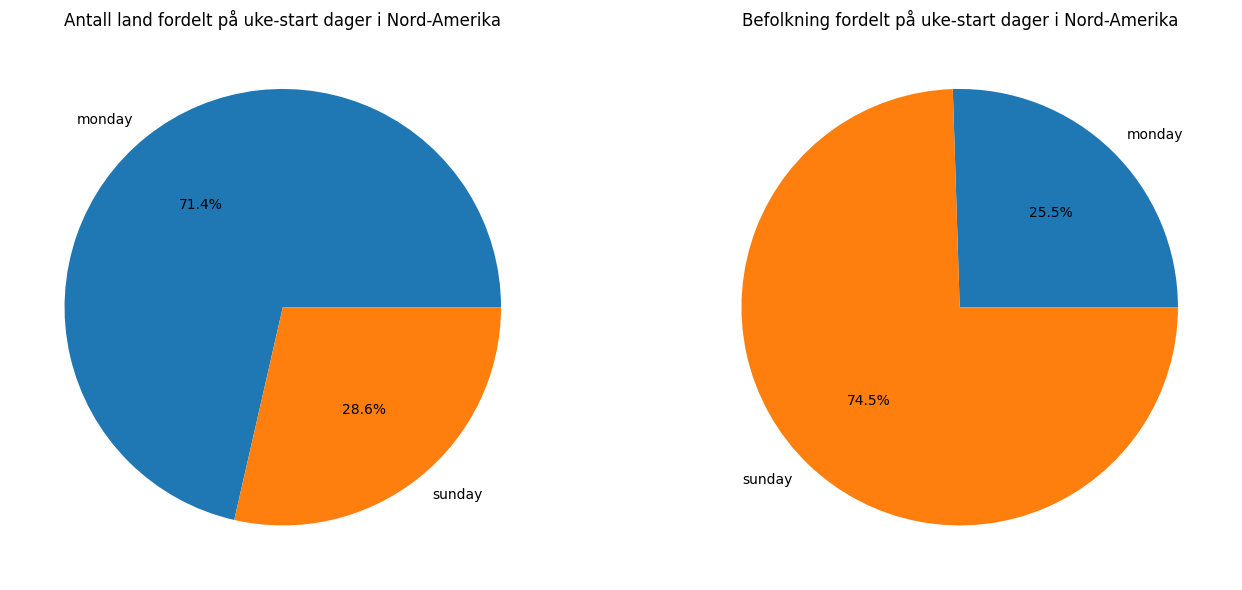

In [567]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

data_grouped.plot(
    kind="pie",
    y="count",
    ylabel="",
    legend=False,
    autopct="%1.1f%%",
    title="Antall land fordelt på uke-start dager i Nord-Amerika",
    ax=axes[0],
)
data_grouped.plot(
    kind="pie",
    y="population",
    ylabel="",
    legend=False,
    autopct="%1.1f%%",
    title="Befolkning fordelt på uke-start dager i Nord-Amerika",
    ax=axes[1],
)

plt.tight_layout()
plt.show()

**Data fra Europa**

Videre skal vi jobbe med data fra Europa. Se på hvordan vi gjorde det med
Nord-Amerika, og fullfør koden under. 
1. Hent data fra API
2. Konverter til `CountryPandas`
3. Konverter til `DataFrame`
4. Velg ut kolonner
    - Vi trenger "name", "currencies", "borders" og "population"
5. Konverter kolonnen "name" til å ha verdi `name_radelement['common']` (str)
6. Konverter kolonnen "currencies" til å ha verdi `currencies_radelement.keys()` (list)


In [ ]:
data_europa_raw = _ # Hent data for Europa fra API
data_europa = _ # Lag CountryPandas objekter fra rådata

europa = _ # Lag DataFrame fra CountryPandas objekter
europa["name"] = europa["name"].apply(_) # Hent ut common navn fra name kolonnen
europa["currencies"] = europa["currencies"].apply(
    # Omgjør currencies dict til en liste av nøkkelverdiene til dict i hver rad
)

**Antall land et land grenser til**

Du skal nå lage en rangert tabell som viser antall land hvert land i europa
grenser til. 

1. Velg ut kolonnene du trenger fra `europa`, `"name"` og `"borders"`
2. Lag en ny kolonne, `"border_count"`, som med antall land landet grenser til
3. Sorter synkende etter den nye kolonnen
4. Velg ut de 20 øverste radene

Resultatet skal se ca slik ut:

![](img/europa_flest_grenser_tabell.png)


In [ ]:
border_counts = _ # Velg ut kolonnene du trenger fra DataFrame europa
border_counts["border_count"] = border_counts["borders"].apply(
    # Lag en ny kolonne som teller antall grenser for hvert land
)
border_counts = _ # Sorter synkende etter border_count kolonnen
top_20_border_counts = _ # Velg ut de 20 øverste radene

# Denne linjen skriver ut resultatet
top_20_border_counts

Lag en bar plot fra `DataFrame` du laget over, `top_20_border_counts.

Resultatet skal se ca slik ut:

![](./img/europa_flest_grenser_diagram.png)

In [ ]:
## Din kode her

Du skal nå velge ut landet med NEST flest landegrenser og skrive ut navnet
på alle landene. Siden kolonnen `"borders"` inneholder en liste med landkode,
må du bruke data fra `europa` framen til å hente ut fullt navn. Du kan matche
landkode fra `"borders"` med koden fra `"cca3"` i `europa`.

1. Hent ut listen over alle land det landet med NEST flest landegrenser grenser til
2. Filtrer radene i `europa` basert på om verdien for `"cca3"` finnes i listen
   du hentet ut i 1. (tips: bruk `isin` funksjonen til en `DataFrame`)
3. Velg ut kolonnen `"name"` fra den filtrerte tabellen og konverter den til en liste
4. Skriv ut resultatet

In [ ]:
## DIN KODE HER

**Valuta i Europa**

I den siste oppgaven øker vi vanskelighetsgraden litt, der du får mindre instruksjoner.

Bruk data fra `europa` til å lage en ny tabell, `currencies_europe`, som lister alle 
valuta i europa, hvor mange land som bruker hver valuta, og samlet befolkningstall som
bruker hver valuta. Valutanavn skal være forkortelser som _EUR_ og _NOK_.

Resultatet skal se ca slik ut:

![](./img/valuta_tabell.png)

In [ ]:
# DIN KODE HER

Du skal nå lage to kakediagram basert på tabellen:
- Et som viser andel land som bruker hver valuta
- Et som viser andel av europas befolkning som bruker hver valuta

For å gjøre figuren mer oversiktlig, skal du også gruppere sammen alle data som
havner under `5 %`. Disse skal grupperes som "Andre". Vær oppmerksom på at 
du må regne ut hvilke land dette gjelder individuelt for de to diagrammene, altså
de valutaer som brukes i mindre enn `5 %` av landene i Europa, og de som brukes av 
mindre enn `5 %` av europas samlede befolkning. 

Diagrammet skal se ca slik ut:

![](img/valuta_eur.png)


> Vanskelig?
> 
> Hvis du ikke får til grupperingen til "Andre" verdier,
> kan du også prøve å lage de to diagrammene uten å gruppere
> de laveste verdiene sammen. 

In [ ]:
# Din kode her

In [ ]:
data_europa_raw = hent_regiondata("europe")
data_europa = [CountryPandas(**land) for land in data_europa_raw]

europa = pd.DataFrame([land.model_dump() for land in data_europa])
europa["name"] = europa["name"].apply(lambda x: x["common"])
europa["currencies"] = europa["currencies"].apply(
    lambda x: list(x.keys()) if x else None
)

border_counts = europa[["name", "borders"]].copy()
border_counts["border_count"] = border_counts["borders"].apply(
    lambda x: len(x) if x else 0
)
border_counts = border_counts.sort_values(
    by="border_count", ascending=False
).reset_index(drop=True)
border_counts.head()
top_border_count = border_counts.iloc[0]["border_count"]
second_top_border_count = border_counts.iloc[1]["border_count"]
second_top_borders = border_counts.iloc[1]["borders"]
second_top_borders_to_names = europa[
    europa["cca3"].isin(second_top_borders)
]["name"].tolist()

top_20_border_counts = border_counts.head(20)

top_20_border_counts

,name,borders,border_count
0,Russia,"[AZE, BLR, CHN, EST, FIN, GEO, KAZ, PRK, LVA, ...",14
1,Germany,"[AUT, BEL, CZE, DNK, FRA, LUX, NLD, POL, CHE]",9
2,Austria,"[CZE, DEU, HUN, ITA, LIE, SVK, SVN, CHE]",8
3,France,"[AND, BEL, DEU, ITA, LUX, MCO, ESP, CHE]",8
4,Serbia,"[BIH, BGR, HRV, HUN, UNK, MKD, MNE, ROU]",8
5,Poland,"[BLR, CZE, DEU, LTU, RUS, SVK, UKR]",7
6,Ukraine,"[BLR, HUN, MDA, POL, ROU, RUS, SVK]",7
7,Hungary,"[AUT, HRV, ROU, SRB, SVK, SVN, UKR]",7
8,Italy,"[AUT, FRA, SMR, SVN, CHE, VAT]",6
9,North Macedonia,"[ALB, BGR, GRC, UNK, SRB]",5


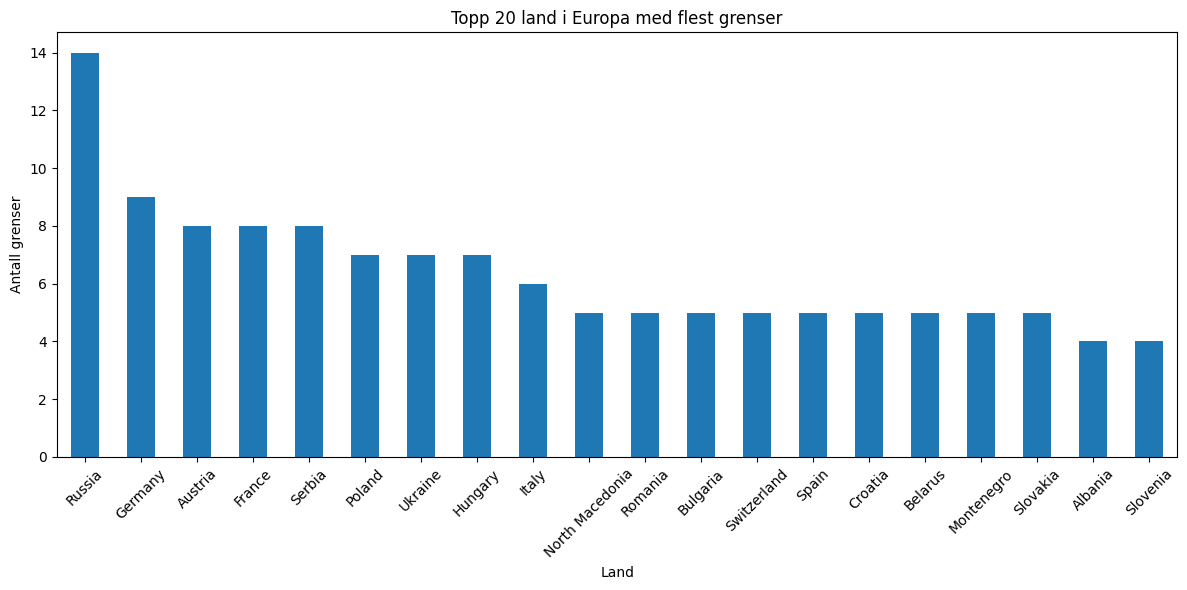

In [ ]:


top_20_border_counts.plot(
    kind="bar",
    x="name",
    y="border_count",
    ylabel="Antall grenser",
    xlabel="Land",
    title="Topp 20 land i Europa med flest grenser",
    legend=False,
    figsize=(12, 6),
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [577]:
currency_pd = europa[["name", "currencies"]].explode("currencies")
currency_counts = currency_pd["currencies"].value_counts().reset_index()
currency_counts.columns = ["currency", "count"]
currency_pop = europa[["name", "currencies", "population"]].explode("currencies")

currency_pop_grouped = currency_pop.groupby("currencies").agg(
    population=("population", "sum"),
    country_count=("name", "count"),
).reset_index()

currency_pop_grouped.head()

,currencies,population,country_count
0,ALL,2363314,1
1,BAM,3422000,1
2,BGN,6437360,1
3,BYN,9109280,1
4,CHF,9123748,2


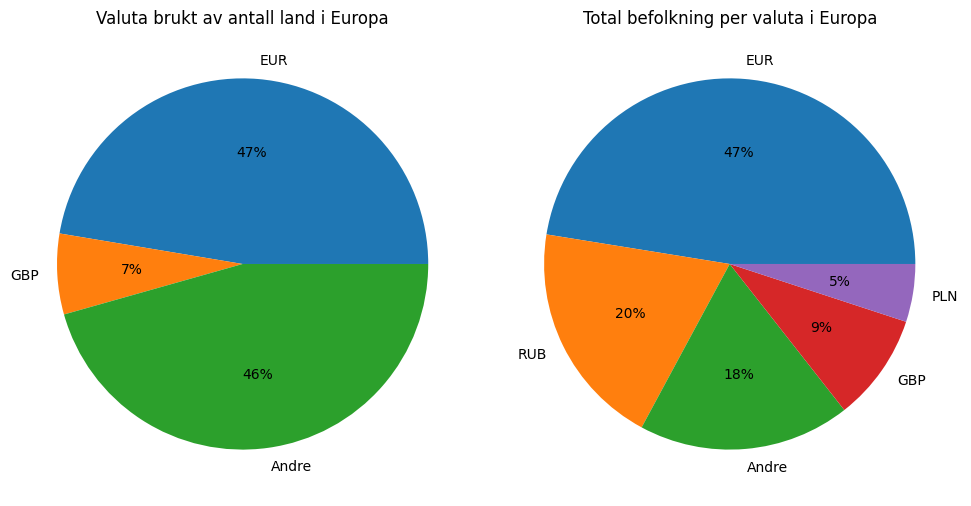

In [556]:
currency_pd = north_america[["name", "currencies"]].explode("currencies")
currency_counts = currency_pd["currencies"].value_counts().reset_index()
currency_counts.columns = ["currency", "count"]
currency_pop = north_america[["name", "currencies", "population"]].explode("currencies")

currency_pop_grouped = currency_pop.groupby("currencies").agg(
    population=("population", "sum"),
    country_count=("name", "count"),
).reset_index()
total_pop = currency_pop["population"].sum()
currency_pop_lower_5pct = currency_pop_grouped[
    currency_pop_grouped["population"] < 0.05 * total_pop
]
currency_count_lower_5pct = currency_pop_grouped[
    currency_pop_grouped["country_count"] < 0.05 * len(north_america)
]
currency_pop_grouped_lower = currency_pop_grouped[
    ~currency_pop_grouped["currencies"].isin(
        currency_pop_lower_5pct["currencies"]
    )
].copy()
currency_count_lower = currency_pop_grouped[
    ~currency_pop_grouped["currencies"].isin(
        currency_count_lower_5pct["currencies"]
    )

].copy()
currency_pop_grouped_lower.loc[len(currency_pop_grouped_lower)] = pd.Series({
    "currencies": "Andre",
    "population": currency_pop_lower_5pct["population"].sum(),
    "pop_pct": currency_pop_lower_5pct["population"].sum() / total_pop * 100,
    "country_count": currency_pop_lower_5pct["country_count"].sum(),
})
currency_count_lower.loc[len(currency_count_lower)] = pd.Series({
    "currencies": "Andre",
    "population": currency_count_lower_5pct["population"].sum(),
    "pop_pct": currency_count_lower_5pct["population"].sum() / total_pop * 100,
    "country_count": currency_count_lower_5pct["country_count"].sum(),
})

currency_pop_grouped_lower = currency_pop_grouped_lower.sort_values(
    by="population", ascending=False
)
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
currency_count_lower.plot(
    kind="pie",
    y="country_count",
    labels=currency_count_lower["currencies"],
    title="Valuta brukt av antall land i Europa",
    legend=False,
    autopct="%1.0f%%",
    ylabel="",
    use_index=False,
    ax=ax[0]
)
currency_pop_grouped_lower.plot(
    kind="pie",
    y="population",
    labels=currency_pop_grouped_lower["currencies"],
    title="Total befolkning per valuta i Europa",
    legend=False,
    autopct="%1.0f%%",
    ylabel="",
    use_index=False,
    ax=ax[1]
)

plt.tight_layout()
plt.show()